# Import

In [1]:
# 데이터 로드
import pandas as pd
import numpy as np
import os
import datetime
import xlrd
from openpyxl import Workbook

# 데이터 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

# torch
import torch
import torch.nn as nn
from tensorflow import nn

# 데이터 정제용
from datetime import datetime
from collections import Counter
from PIL import Image

# 코딩 도우미(?)
from IPython.display import clear_output
import requests
import re
from tqdm import tqdm

# 주가 데이터
import FinanceDataReader as fdr
from pandas_datareader import data as pdr

In [2]:
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

# 1-1 Kospi Top 30 데이터 주가 데이터

In [3]:
# option

# 주가 선정 종목코드 <2022년 마지막 거래일 기준 시총 탑 30>
stock_code=['005930','373220','207940','000660','051910',
            '005935','006400','005380','035420','000270',
            '035720','005490','068270','028260','105560',
            '012330','055550','096770','032830','066570',
            '034730','015760','003670','033780','086790',
            '003550','051900','010130','017670','329180']

In [4]:
krx=fdr.StockListing('KRX')

stock_name = krx[['Code','Name']] # 한국거래소 상장 종목들 불러오기

stock_name1 = stock_name[stock_name['Code'].isin(stock_code)] # 선정 종목들 불러오기
stock_name1 = stock_name1.reset_index()
stock_name1 = stock_name1.drop(['index'],axis=1)

price=[]
for i in range(len(stock_name1)):
    price.append(fdr.DataReader('{}'.format(stock_name1['Code'][i]),'2018-01-01', '2023-01-01'))  
    price[i].to_csv('./kospi30/{}.csv'.format(stock_name1['Name'][i]))

# 1-2 Kospi Top 30 시가총액 / 상장주식수

In [5]:
kospi30_df = pd.read_csv('./kospi30 시가총액.csv', encoding = 'cp949')
kospi30_df['시가총액비율'] = kospi30_df['시가총액']/kospi30_df['시가총액'].sum()
kospi30_df.head()

,종목코드,종목명,시가총액,상장주식수,시가총액비율
0,5930,삼성전자,3.301290e+14,5969782550,0.309249
1,373220,LG에너지솔루션,1.019070e+14,234000000,0.095461
2,207940,삼성바이오로직스,5.843390e+13,71174000,0.054738
3,660,SK하이닉스,5.460020e+13,728002365,0.051147
4,51910,LG화학,4.235540e+13,70592343,0.039676


# 1-3 빅카인즈 뉴스 데이터(5년 치) 불러오기 및 전처리

In [6]:
# 뉴스 데이터 병합
path = './빅카인즈 2018~2023/'

file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.xlsx')]

kospi30_news = pd.DataFrame()
for i in tqdm(file_list_py) :
    data = pd.read_excel(path + i)
    data = data[['뉴스 식별자','일자','제목']]
    
    kospi30_news = kospi30_news.append(data)

100%|██████████| 5/5 [00:22<00:00,  4.43s/it]


In [7]:
print("총 뉴스 행 개수: ",len(kospi30_news))

총 뉴스 행 개수:  57778


In [8]:
# 병합 파일 csv로 저장 및 불러오기
kospi30_news.to_csv('kospi30_news.csv')
news_df = pd.read_csv("./kospi30_news.csv").iloc[:,1:4] #위 과정에서 생긴 불필요한 0번째 열 제거

In [9]:
# 전처리 0. float 형태로 표현된 '뉴스 식별자'열 문자열로 바꿔주기
news_df[['뉴스 식별자']] = (news_df[['뉴스 식별자']] - news_df[['뉴스 식별자']].astype(int)).astype(str)

In [10]:
# 전처리 1. 뉴스 식별자 년 / 월 / 일 / 시 단위로 구분하기
news_df['연도'] = news_df['뉴스 식별자'].str[2:6].astype(int)
news_df['월'] = news_df['뉴스 식별자'].str[6:8].astype(int)
news_df['일'] = news_df['뉴스 식별자'].str[8:10].astype(int)
news_df['시'] = news_df['뉴스 식별자'].str[10:12].astype(int)

# 1-4 종목명 불러오기 및 뉴스에 관련 종목 붙여주기

In [11]:
stock_list = list(kospi30_df['종목명'].unique())
print("Kospi Top30 종목명:", stock_list)
print("선정종목수:",len(stock_list),'개')

Kospi Top30 종목명: ['삼성전자', 'LG에너지솔루션', '삼성바이오로직스', 'SK하이닉스', 'LG화학', '삼성전자우', '삼성SDI', '현대차', 'NAVER', '기아', '카카오', 'POSCO홀딩스', '셀트리온', '삼성물산', 'KB금융', '현대모비스', '신한지주', 'SK이노베이션', '삼성생명', 'LG전자', 'SK', '한국전력', '포스코케미칼', 'KT&G', '하나금융지주', 'LG', 'LG생활건강', '고려아연', 'SK텔레콤', '현대중공업']
선정종목수: 30 개


In [12]:
# 제목에서 종목명 추출
news_df['종목명'] = 'default'
data_mt = []    # multiple title

for sl in tqdm(stock_list) :
    for i in range(len(news_df)) :
        if sl in news_df.loc[i, '제목'].upper() :         # 제목에 종목명이 있을 때(대문자로 통일)
            if news_df.loc[i, '종목명'] == 'default' :    # 종목명이 하나인 경우
                news_df.loc[i, '종목명'] = sl             # 종목명 부여
                
            else :                                     # 종목명이 여러개인 경우
                row_tmp = news_df.loc[i]                  # 행 복사
                row_tmp['종목명'] = sl                 # 종목명 부여
                data_mt.append(row_tmp)
news_df_mt = pd.DataFrame(data_mt)
news_df_mt

100%|██████████| 30/30 [00:22<00:00,  1.33it/s]


,뉴스 식별자,일자,제목,연도,월,일,시,종목명
47276,0.20221114112064242,20221114,"KB증권 ""주식 소수점매매 절반은 삼성전자-LG에너지솔루션""",2022,11,14,11,LG에너지솔루션
1470,0.2018111301586032,20181113,"삼성전자, 삼성바이오로직스 주가 하락 타격 미미-하나",2018,11,13,1,삼성바이오로직스
1568,0.20181109011173248,20181109,"[한경로보뉴스] 전일, 기관 거래소에서 삼성전자(+0.11%), 삼성바이오로직스(-...",2018,11,9,1,삼성바이오로직스
11511,0.20180115196853876,20180115,[이 종목은 왜?] 오늘의 특징주! #가상화폐 관련주 #삼성전자 #삼성바이오로직스 ...,2018,1,15,19,삼성바이오로직스
18180,0.20190508104860783,20190508,"08일, 기관 거래소에서 삼성전자(-1.34%), 삼성바이오로직스(-7.74%) 등...",2019,5,8,10,삼성바이오로직스
...,...,...,...,...,...,...,...,...
49547,0.202209051232785,20220905,"현대중공업, 3917억 규모 VLGC 3척 수주 [주목 e공시]",2022,9,5,12,현대중공업
50466,0.20220801094546914,20220801,"[장마감 기관 순매수 상위종목] 연기금은 현대중공업, LG에너지솔루션, 투신은",2022,8,1,9,현대중공업
52985,0.20220513083040714,20220513,"현대중공업, MSCI 지수 편입 '탈락설' SKT는 잔류",2022,5,13,8,현대중공업
52991,0.20220513083040714,20220513,"현대중공업 MSCI 한국지수 신규 편입, 편출설 돌던 SKT 잔류",2022,5,13,8,현대중공업


In [13]:
# 최종 뉴스 및 종목명 파일들 병합
final_news = pd.concat([news_df,news_df_mt])
final_news = final_news.reset_index(drop=True)
final_news

,뉴스 식별자,일자,제목,연도,월,일,시,종목명
0,0.2018123110756278,20181231,"삼성전자, 유럽 자율주행차 특허출원 1위",2018,12,31,10,삼성전자
1,0.2018123110756278,20181231,"2018년 일몰-2019년 일출, SK이노 인천 울산에서 생중계",2018,12,31,10,SK
2,0.2018123110756278,20181231,"LG생활건강 올해 특명 ""수한방, 제2의 후로 키워라""",2018,12,31,10,LG
3,0.2018123110756278,20181231,삼성 LG '자율주행차 특허' 강자,2018,12,31,10,LG
4,0.2018123110756278,20181231,셀트리온 삼성바이오 등 1월 JP모건 헬스케어 총출동,2018,12,31,10,셀트리온
...,...,...,...,...,...,...,...,...
73659,0.202209051232785,20220905,"현대중공업, 3917억 규모 VLGC 3척 수주 [주목 e공시]",2022,9,5,12,현대중공업
73660,0.20220801094546914,20220801,"[장마감 기관 순매수 상위종목] 연기금은 현대중공업, LG에너지솔루션, 투신은",2022,8,1,9,현대중공업
73661,0.20220513083040714,20220513,"현대중공업, MSCI 지수 편입 '탈락설' SKT는 잔류",2022,5,13,8,현대중공업
73662,0.20220513083040714,20220513,"현대중공업 MSCI 한국지수 신규 편입, 편출설 돌던 SKT 잔류",2022,5,13,8,현대중공업


In [14]:
# 중복 행 제거
final_news = final_news.drop_duplicates(ignore_index=True)
final_news

,뉴스 식별자,일자,제목,연도,월,일,시,종목명
0,0.2018123110756278,20181231,"삼성전자, 유럽 자율주행차 특허출원 1위",2018,12,31,10,삼성전자
1,0.2018123110756278,20181231,"2018년 일몰-2019년 일출, SK이노 인천 울산에서 생중계",2018,12,31,10,SK
2,0.2018123110756278,20181231,"LG생활건강 올해 특명 ""수한방, 제2의 후로 키워라""",2018,12,31,10,LG
3,0.2018123110756278,20181231,삼성 LG '자율주행차 특허' 강자,2018,12,31,10,LG
4,0.2018123110756278,20181231,셀트리온 삼성바이오 등 1월 JP모건 헬스케어 총출동,2018,12,31,10,셀트리온
...,...,...,...,...,...,...,...,...
73534,0.202209051232785,20220905,"현대중공업, 3917억 규모 VLGC 3척 수주 [주목 e공시]",2022,9,5,12,현대중공업
73535,0.20220801094546914,20220801,"[장마감 기관 순매수 상위종목] 연기금은 현대중공업, LG에너지솔루션, 투신은",2022,8,1,9,현대중공업
73536,0.20220513083040714,20220513,"현대중공업, MSCI 지수 편입 '탈락설' SKT는 잔류",2022,5,13,8,현대중공업
73537,0.20220513083040714,20220513,"현대중공업 MSCI 한국지수 신규 편입, 편출설 돌던 SKT 잔류",2022,5,13,8,현대중공업


In [15]:
# 종목별 뉴스빈도율 구하기
final_news_value = final_news['종목명'].value_counts(normalize=True).to_frame().reset_index()
final_news_value.columns = ['종목명', '뉴스빈도율']
final_news_value.head()

,종목명,뉴스빈도율
0,LG,0.179537
1,SK,0.167653
2,삼성전자,0.132814
3,현대차,0.128938
4,카카오,0.056977


# 1-5 뉴스데이터 및 시가총액 비율, 뉴스빈도율 병합

In [16]:
final_df = pd.merge(final_news, kospi30_df[['종목명','시가총액비율']])
final_df = pd.merge(final_df, final_news_value)
final_df

,뉴스 식별자,일자,제목,연도,월,일,시,종목명,시가총액비율,뉴스빈도율
0,0.2018123110756278,20181231,"삼성전자, 유럽 자율주행차 특허출원 1위",2018,12,31,10,삼성전자,0.309249,0.132814
1,0.2018123110756278,20181231,"[2018 Hot-Line] 삼성전자, 액면분할 이후 주가 27%↓",2018,12,31,10,삼성전자,0.309249,0.132814
2,0.20181230083107948,20181230,삼성전자 사업부문장 CES 총출동 초격차 더 벌린다,2018,12,30,8,삼성전자,0.309249,0.132814
3,0.2018122998997569,20181230,[이슈+] 증시 울상에 대형주 시총 25% 증발 삼성전자 98조 ↓,2018,12,29,98,삼성전자,0.309249,0.132814
4,0.20181229198351502,20181229,"中 화웨이 스마트폰, 러 시장에서 인기 삼성전자 제쳤다",2018,12,29,19,삼성전자,0.309249,0.132814
...,...,...,...,...,...,...,...,...,...,...
73534,0.20220127096399665,20220127,"[단독] SK텔레콤, 전 임직원에 성과급 쏜다 ""성과 따라 차등 지급""",2022,1,27,9,SK텔레콤,0.009717,0.012823
73535,0.20220120018348098,20220120,"SK스토아, SK텔레콤 'T우주'와 제휴 매달 20% 할인",2022,1,20,1,SK텔레콤,0.009717,0.012823
73536,0.20220105117186904,20220105,"전력 사용량 줄이는 반도체 SK텔레콤, 그린ICT 기술 공개 [CES 2022]",2022,1,5,11,SK텔레콤,0.009717,0.012823
73537,0.20220103999599814,20220104,"SK텔레콤, 인공지능 기반 'T우주' 구독서비스 메타버스까지 사업영토 확 넓힌다",2022,1,3,99,SK텔레콤,0.009717,0.012823


# 2-1 뉴스 제목 감성분석을 위한 GPU 설정 및 할당 !!!!! 구글 코랩으로 대체하여 진행 !!!!!

In [ ]:
import tensorflow as tf

In [ ]:
''' # 텐서플로우 GPU할당 확인
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices()) '''

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11988290540283847292
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9399762944
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13497711814549509367
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:b3:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
import torch

torch.cuda.is_available()

True

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


# 2-2 KR-FinBERT 감성분석 !!!!! 구글 코랩으로 대체하여 진행 !!!!!

In [ ]:
# 모델 입력을 위해 리스트 형태로 변환
texts = list(data['제목'])

texts[0]

'삼성전자 공장 건설 트럼프는 땡큐, 특검은 특혜'

In [ ]:
# 사전학습 모델 load
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-FinBert-SC")
model = AutoModelForSequenceClassification.from_pretrained("snunlp/KR-FinBert-SC").to(device)

Downloading:   0%|          | 0.00/372 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/143k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/294k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/881 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/406M [00:00<?, ?B/s]

In [ ]:
tokenizer.tokenize(texts[0])

['삼성전자', '공장', '건설', '트럼프는', '땡', '##큐', ',', '특검', '##은', '특혜']

In [ ]:
# 사전학습 모델에 데이터 입력

outputs_list = []
for text in tqdm(texts) :
    inputs = tokenizer(text, return_tensors='pt').to(device)
    output = model(**inputs)
    output = output.logits.tolist()[0]
    outputs_list.append(output)

100%|██████████| 73539/73539 [15:28<00:00, 79.20it/s]


In [ ]:
# 출력값을 텐서로 변환

outputs = torch.tensor(outputs_list)
outputs

tensor([[ 5.2036, -2.9333, -2.3997],
        [-2.4505, -0.8543,  3.6936],
        [-1.0011,  3.1971, -1.9443],
        ...,
        [-3.0320,  5.7965, -2.0608],
        [-3.5052,  5.3015, -1.2294],
        [-2.5815, -2.5521,  5.2078]])

In [ ]:
# 출력값을 확률 형태로 변환
import torch.nn.functional as F

predictions = F.softmax(outputs, dim=-1)
predictions

tensor([[9.9921e-01, 2.9231e-04, 4.9841e-04],
        [2.1191e-03, 1.0456e-02, 9.8742e-01],
        [1.4716e-02, 9.7955e-01, 5.7302e-03],
        ...,
        [1.4641e-04, 9.9947e-01, 3.8668e-04],
        [1.4949e-04, 9.9840e-01, 1.4554e-03],
        [4.1380e-04, 4.2614e-04, 9.9916e-01]])

In [ ]:
# 출력값 확인

df_sc = pd.DataFrame(predictions.detach().numpy())
df_sc.columns = ['부정','중립','긍정']
df_sc

,부정,중립,긍정
0,0.999209,0.000292,0.000498
1,0.002119,0.010456,0.987425
2,0.014716,0.979554,0.005730
3,0.999681,0.000052,0.000268
4,0.000097,0.000087,0.999817
...,...,...,...
73534,0.012864,0.125912,0.861224
73535,0.000043,0.000103,0.999854
73536,0.000146,0.999467,0.000387
73537,0.000149,0.998395,0.001455


In [ ]:
data = pd.concat([data, df_sc], axis=1)
data

,일자,연도,월,일,시,제목,종목명,시가총액비율,부정,중립,긍정
0,20180101,2018,1,1,18,"삼성전자 공장 건설 트럼프는 땡큐, 특검은 특혜",삼성전자,0.309249,0.999209,0.000292,0.000498
1,20180101,2018,1,1,8,"[대도약 2018 다시 뛰는 기업들] 삼성전자, ""전부문 초격차 전략으로 시장 주도""",삼성전자,0.309249,0.002119,0.010456,0.987425
2,20180102,2018,1,2,20,"김기남 사장 ""삼성전자, 자만 말고 초심으로 새롭게 도전""",삼성전자,0.309249,0.014716,0.979554,0.005730
3,20180102,2018,1,2,20,"美업체, 삼성전자 SK하이닉스 특허침해 소송 ""통상문제 아니다""",삼성전자,0.309249,0.999681,0.000052,0.000268
4,20180102,2018,1,2,20,"""크기의전쟁 시작됐다"" 삼성전자, 글로벌 대형 TV 시장서 1위",삼성전자,0.309249,0.000097,0.000087,0.999817
...,...,...,...,...,...,...,...,...,...,...,...
73534,20221214,2022,12,14,8,'위약금 없는' 온라인 요금제 가입문턱 확 낮춘 SK텔레콤,SK텔레콤,0.009717,0.012864,0.125912,0.861224
73535,20221214,2022,12,14,8,"SK텔레콤, 20일 신규 온라인 요금제 출시 ""결합상품 가입 가능""",SK텔레콤,0.009717,0.000043,0.000103,0.999854
73536,20221221,2022,12,21,12,SK텔레콤 쿠폰 구독 'T우주' 이번엔 미술 작품 등 정기배송,SK텔레콤,0.009717,0.000146,0.999467,0.000387
73537,20221221,2022,12,20,98,우유 캡슐커피까지 '정기배송' SK텔레콤 새 구독서비스,SK텔레콤,0.009717,0.000149,0.998395,0.001455


In [ ]:
data.to_csv('kospi30_FAG.csv', index=False, encoding='utf-8-sig')

# 3-1 감성수치 및 반응도 + 감정 별 빈도 확인하기

In [23]:
df_score = pd.read_csv("kospi30_FAG.csv", encoding='utf-8-sig')
df_score

,일자,연도,월,일,시,제목,종목명,시가총액비율,종목별뉴스빈도율,부정,중립,긍정
0,20180101,2018,1,1,18,"삼성전자 공장 건설 트럼프는 땡큐, 특검은 특혜",삼성전자,0.309249,0.132814,0.999209,0.000292,0.000498
1,20180101,2018,1,1,8,"[대도약 2018 다시 뛰는 기업들] 삼성전자, ""전부문 초격차 전략으로 시장 주도""",삼성전자,0.309249,0.132814,0.002119,0.010456,0.987425
2,20180102,2018,1,2,20,"김기남 사장 ""삼성전자, 자만 말고 초심으로 새롭게 도전""",삼성전자,0.309249,0.132814,0.014716,0.979554,0.005730
3,20180102,2018,1,2,20,"美업체, 삼성전자 SK하이닉스 특허침해 소송 ""통상문제 아니다""",삼성전자,0.309249,0.132814,0.999681,0.000052,0.000268
4,20180102,2018,1,2,20,"""크기의전쟁 시작됐다"" 삼성전자, 글로벌 대형 TV 시장서 1위",삼성전자,0.309249,0.132814,0.000097,0.000087,0.999817
...,...,...,...,...,...,...,...,...,...,...,...,...
73534,20221214,2022,12,14,8,'위약금 없는' 온라인 요금제 가입문턱 확 낮춘 SK텔레콤,SK텔레콤,0.009717,0.012823,0.012864,0.125912,0.861224
73535,20221214,2022,12,14,8,"SK텔레콤, 20일 신규 온라인 요금제 출시 ""결합상품 가입 가능""",SK텔레콤,0.009717,0.012823,0.000043,0.000103,0.999854
73536,20221221,2022,12,21,12,SK텔레콤 쿠폰 구독 'T우주' 이번엔 미술 작품 등 정기배송,SK텔레콤,0.009717,0.012823,0.000146,0.999467,0.000387
73537,20221221,2022,12,20,98,우유 캡슐커피까지 '정기배송' SK텔레콤 새 구독서비스,SK텔레콤,0.009717,0.012823,0.000149,0.998395,0.001455


In [24]:
df_score['감정'] = ''

for i in tqdm(range(len(df_score))) :
    if df_score['부정'].iloc[i] > df_score['중립'].iloc[i] and df_score['부정'].iloc[i] > df_score['긍정'].iloc[i] :
        df_score['감정'].iloc[i] = '부정'
    
    elif df_score['긍정'].iloc[i] > df_score['중립'].iloc[i] and df_score['긍정'].iloc[i] > df_score['부정'].iloc[i] :
        df_score['감정'].iloc[i] = '긍정'
    
    else :
        df_score['감정'].iloc[i] = '중립'

df_score.head()

100%|██████████| 73539/73539 [00:21<00:00, 3467.75it/s]


,일자,연도,월,일,시,제목,종목명,시가총액비율,종목별뉴스빈도율,부정,중립,긍정,감정
0,20180101,2018,1,1,18,"삼성전자 공장 건설 트럼프는 땡큐, 특검은 특혜",삼성전자,0.309249,0.132814,0.999209,0.000292,0.000498,부정
1,20180101,2018,1,1,8,"[대도약 2018 다시 뛰는 기업들] 삼성전자, ""전부문 초격차 전략으로 시장 주도""",삼성전자,0.309249,0.132814,0.002119,0.010456,0.987425,긍정
2,20180102,2018,1,2,20,"김기남 사장 ""삼성전자, 자만 말고 초심으로 새롭게 도전""",삼성전자,0.309249,0.132814,0.014716,0.979554,0.005730,중립
3,20180102,2018,1,2,20,"美업체, 삼성전자 SK하이닉스 특허침해 소송 ""통상문제 아니다""",삼성전자,0.309249,0.132814,0.999681,0.000052,0.000268,부정
4,20180102,2018,1,2,20,"""크기의전쟁 시작됐다"" 삼성전자, 글로벌 대형 TV 시장서 1위",삼성전자,0.309249,0.132814,0.000097,0.000087,0.999817,긍정


In [25]:
df_score['감정'].value_counts()

긍정    38590
중립    22106
부정    12843
Name: 감정, dtype: int64

In [26]:
df_score = df_score[df_score['감정'] != '중립']

In [27]:
# 감성수치/반응도 산출
# 감성수치 : 긍정과 부정 중 더 높은 값 
# 반응도 : 감성수치의 절대값

df_score['감성수치'] = np.where(df_score['부정'] >= df_score['긍정'], -df_score['부정'], df_score['긍정'])

df_score['반응도'] = np.where(df_score['부정'] >= df_score['긍정'], df_score['부정'], df_score['긍정'])
df_score

,일자,연도,월,일,시,제목,종목명,시가총액비율,종목별뉴스빈도율,부정,중립,긍정,감정,감성수치,반응도
0,20180101,2018,1,1,18,"삼성전자 공장 건설 트럼프는 땡큐, 특검은 특혜",삼성전자,0.309249,0.132814,0.999209,0.000292,0.000498,부정,-0.999209,0.999209
1,20180101,2018,1,1,8,"[대도약 2018 다시 뛰는 기업들] 삼성전자, ""전부문 초격차 전략으로 시장 주도""",삼성전자,0.309249,0.132814,0.002119,0.010456,0.987425,긍정,0.987425,0.987425
3,20180102,2018,1,2,20,"美업체, 삼성전자 SK하이닉스 특허침해 소송 ""통상문제 아니다""",삼성전자,0.309249,0.132814,0.999681,0.000052,0.000268,부정,-0.999681,0.999681
4,20180102,2018,1,2,20,"""크기의전쟁 시작됐다"" 삼성전자, 글로벌 대형 TV 시장서 1위",삼성전자,0.309249,0.132814,0.000097,0.000087,0.999817,긍정,0.999817,0.999817
5,20180102,2018,1,2,1,"美기업, 삼성전자 SK하이닉스 겨냥 반도체특허 소송 제기",삼성전자,0.309249,0.132814,0.999751,0.000050,0.000199,부정,-0.999751,0.999751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73531,20221116,2022,11,16,11,"SK텔레콤, AI 기술로 보이스피싱 예방 등 고객보호 앞장",SK텔레콤,0.009717,0.012823,0.002881,0.202523,0.794596,긍정,0.794596,0.794596
73532,20221121,2022,11,21,9,SK텔레콤-日 통신 1위 맞손 韓 日 메타버스 국경 뚫는다,SK텔레콤,0.009717,0.012823,0.000078,0.000183,0.999739,긍정,0.999739,0.999739
73534,20221214,2022,12,14,8,'위약금 없는' 온라인 요금제 가입문턱 확 낮춘 SK텔레콤,SK텔레콤,0.009717,0.012823,0.012864,0.125912,0.861224,긍정,0.861224,0.861224
73535,20221214,2022,12,14,8,"SK텔레콤, 20일 신규 온라인 요금제 출시 ""결합상품 가입 가능""",SK텔레콤,0.009717,0.012823,0.000043,0.000103,0.999854,긍정,0.999854,0.999854


In [28]:
df_score['감정'].value_counts()

긍정    38590
부정    12843
Name: 감정, dtype: int64

# 3-2 벤치마킹 용 동일 가중치 컬럼 추가

In [29]:
df_score['감성수치_벤치마킹'] = df_score['감성수치'] / 30
df_score['반응도_벤치마킹'] = df_score['반응도'] / 30
df_score

,일자,연도,월,일,시,제목,종목명,시가총액비율,종목별뉴스빈도율,부정,중립,긍정,감정,감성수치,반응도,감성수치_벤치마킹,반응도_벤치마킹
0,20180101,2018,1,1,18,"삼성전자 공장 건설 트럼프는 땡큐, 특검은 특혜",삼성전자,0.309249,0.132814,0.999209,0.000292,0.000498,부정,-0.999209,0.999209,-0.033307,0.033307
1,20180101,2018,1,1,8,"[대도약 2018 다시 뛰는 기업들] 삼성전자, ""전부문 초격차 전략으로 시장 주도""",삼성전자,0.309249,0.132814,0.002119,0.010456,0.987425,긍정,0.987425,0.987425,0.032914,0.032914
3,20180102,2018,1,2,20,"美업체, 삼성전자 SK하이닉스 특허침해 소송 ""통상문제 아니다""",삼성전자,0.309249,0.132814,0.999681,0.000052,0.000268,부정,-0.999681,0.999681,-0.033323,0.033323
4,20180102,2018,1,2,20,"""크기의전쟁 시작됐다"" 삼성전자, 글로벌 대형 TV 시장서 1위",삼성전자,0.309249,0.132814,0.000097,0.000087,0.999817,긍정,0.999817,0.999817,0.033327,0.033327
5,20180102,2018,1,2,1,"美기업, 삼성전자 SK하이닉스 겨냥 반도체특허 소송 제기",삼성전자,0.309249,0.132814,0.999751,0.000050,0.000199,부정,-0.999751,0.999751,-0.033325,0.033325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73531,20221116,2022,11,16,11,"SK텔레콤, AI 기술로 보이스피싱 예방 등 고객보호 앞장",SK텔레콤,0.009717,0.012823,0.002881,0.202523,0.794596,긍정,0.794596,0.794596,0.026487,0.026487
73532,20221121,2022,11,21,9,SK텔레콤-日 통신 1위 맞손 韓 日 메타버스 국경 뚫는다,SK텔레콤,0.009717,0.012823,0.000078,0.000183,0.999739,긍정,0.999739,0.999739,0.033325,0.033325
73534,20221214,2022,12,14,8,'위약금 없는' 온라인 요금제 가입문턱 확 낮춘 SK텔레콤,SK텔레콤,0.009717,0.012823,0.012864,0.125912,0.861224,긍정,0.861224,0.861224,0.028707,0.028707
73535,20221214,2022,12,14,8,"SK텔레콤, 20일 신규 온라인 요금제 출시 ""결합상품 가입 가능""",SK텔레콤,0.009717,0.012823,0.000043,0.000103,0.999854,긍정,0.999854,0.999854,0.033328,0.033328


# 3-3 시가총액 비율을 가중치로 선정하여 컬럼 추가 

In [30]:
df_score['감성수치_mc'] = df_score['감성수치'] * df_score['시가총액비율']
df_score['반응도_mc'] = df_score['반응도'] * df_score['시가총액비율']
df_score

,일자,연도,월,일,시,제목,종목명,시가총액비율,종목별뉴스빈도율,부정,중립,긍정,감정,감성수치,반응도,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc
0,20180101,2018,1,1,18,"삼성전자 공장 건설 트럼프는 땡큐, 특검은 특혜",삼성전자,0.309249,0.132814,0.999209,0.000292,0.000498,부정,-0.999209,0.999209,-0.033307,0.033307,-0.309004,0.309004
1,20180101,2018,1,1,8,"[대도약 2018 다시 뛰는 기업들] 삼성전자, ""전부문 초격차 전략으로 시장 주도""",삼성전자,0.309249,0.132814,0.002119,0.010456,0.987425,긍정,0.987425,0.987425,0.032914,0.032914,0.305360,0.305360
3,20180102,2018,1,2,20,"美업체, 삼성전자 SK하이닉스 특허침해 소송 ""통상문제 아니다""",삼성전자,0.309249,0.132814,0.999681,0.000052,0.000268,부정,-0.999681,0.999681,-0.033323,0.033323,-0.309150,0.309150
4,20180102,2018,1,2,20,"""크기의전쟁 시작됐다"" 삼성전자, 글로벌 대형 TV 시장서 1위",삼성전자,0.309249,0.132814,0.000097,0.000087,0.999817,긍정,0.999817,0.999817,0.033327,0.033327,0.309192,0.309192
5,20180102,2018,1,2,1,"美기업, 삼성전자 SK하이닉스 겨냥 반도체특허 소송 제기",삼성전자,0.309249,0.132814,0.999751,0.000050,0.000199,부정,-0.999751,0.999751,-0.033325,0.033325,-0.309171,0.309171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73531,20221116,2022,11,16,11,"SK텔레콤, AI 기술로 보이스피싱 예방 등 고객보호 앞장",SK텔레콤,0.009717,0.012823,0.002881,0.202523,0.794596,긍정,0.794596,0.794596,0.026487,0.026487,0.007721,0.007721
73532,20221121,2022,11,21,9,SK텔레콤-日 통신 1위 맞손 韓 日 메타버스 국경 뚫는다,SK텔레콤,0.009717,0.012823,0.000078,0.000183,0.999739,긍정,0.999739,0.999739,0.033325,0.033325,0.009714,0.009714
73534,20221214,2022,12,14,8,'위약금 없는' 온라인 요금제 가입문턱 확 낮춘 SK텔레콤,SK텔레콤,0.009717,0.012823,0.012864,0.125912,0.861224,긍정,0.861224,0.861224,0.028707,0.028707,0.008368,0.008368
73535,20221214,2022,12,14,8,"SK텔레콤, 20일 신규 온라인 요금제 출시 ""결합상품 가입 가능""",SK텔레콤,0.009717,0.012823,0.000043,0.000103,0.999854,긍정,0.999854,0.999854,0.033328,0.033328,0.009715,0.009715


# 3-4 뉴스 발생 빈도 비율을 가중치로 선정하여 컬럼 추가

In [31]:
df_score['감성수치_ns'] = df_score['감성수치'] * df_score['종목별뉴스빈도율']
df_score['반응도_ns'] = df_score['반응도'] * df_score['종목별뉴스빈도율']
df_score

,일자,연도,월,일,시,제목,종목명,시가총액비율,종목별뉴스빈도율,부정,...,긍정,감정,감성수치,반응도,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc,감성수치_ns,반응도_ns
0,20180101,2018,1,1,18,"삼성전자 공장 건설 트럼프는 땡큐, 특검은 특혜",삼성전자,0.309249,0.132814,0.999209,...,0.000498,부정,-0.999209,0.999209,-0.033307,0.033307,-0.309004,0.309004,-0.132709,0.132709
1,20180101,2018,1,1,8,"[대도약 2018 다시 뛰는 기업들] 삼성전자, ""전부문 초격차 전략으로 시장 주도""",삼성전자,0.309249,0.132814,0.002119,...,0.987425,긍정,0.987425,0.987425,0.032914,0.032914,0.305360,0.305360,0.131144,0.131144
3,20180102,2018,1,2,20,"美업체, 삼성전자 SK하이닉스 특허침해 소송 ""통상문제 아니다""",삼성전자,0.309249,0.132814,0.999681,...,0.000268,부정,-0.999681,0.999681,-0.033323,0.033323,-0.309150,0.309150,-0.132771,0.132771
4,20180102,2018,1,2,20,"""크기의전쟁 시작됐다"" 삼성전자, 글로벌 대형 TV 시장서 1위",삼성전자,0.309249,0.132814,0.000097,...,0.999817,긍정,0.999817,0.999817,0.033327,0.033327,0.309192,0.309192,0.132790,0.132790
5,20180102,2018,1,2,1,"美기업, 삼성전자 SK하이닉스 겨냥 반도체특허 소송 제기",삼성전자,0.309249,0.132814,0.999751,...,0.000199,부정,-0.999751,0.999751,-0.033325,0.033325,-0.309171,0.309171,-0.132781,0.132781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73531,20221116,2022,11,16,11,"SK텔레콤, AI 기술로 보이스피싱 예방 등 고객보호 앞장",SK텔레콤,0.009717,0.012823,0.002881,...,0.794596,긍정,0.794596,0.794596,0.026487,0.026487,0.007721,0.007721,0.010189,0.010189
73532,20221121,2022,11,21,9,SK텔레콤-日 통신 1위 맞손 韓 日 메타버스 국경 뚫는다,SK텔레콤,0.009717,0.012823,0.000078,...,0.999739,긍정,0.999739,0.999739,0.033325,0.033325,0.009714,0.009714,0.012820,0.012820
73534,20221214,2022,12,14,8,'위약금 없는' 온라인 요금제 가입문턱 확 낮춘 SK텔레콤,SK텔레콤,0.009717,0.012823,0.012864,...,0.861224,긍정,0.861224,0.861224,0.028707,0.028707,0.008368,0.008368,0.011044,0.011044
73535,20221214,2022,12,14,8,"SK텔레콤, 20일 신규 온라인 요금제 출시 ""결합상품 가입 가능""",SK텔레콤,0.009717,0.012823,0.000043,...,0.999854,긍정,0.999854,0.999854,0.033328,0.033328,0.009715,0.009715,0.012821,0.012821


# 3-5 T시점의 15시부터 T+1시점의 15시까지 발생하는 뉴스는 T+1 시점의 가격(15시 기준 종가)을 움직이므로 시점 맞춰주기

In [32]:
# 일자, 시간에 맞춰 정렬해주기
df_score = df_score.sort_values(by = ['일자','시'])
df_score = df_score.reset_index(drop=True)
df_score

,일자,연도,월,일,시,제목,종목명,시가총액비율,종목별뉴스빈도율,부정,...,긍정,감정,감성수치,반응도,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc,감성수치_ns,반응도_ns
0,20180101,2018,1,1,8,"[대도약 2018 다시 뛰는 기업들] 삼성전자, ""전부문 초격차 전략으로 시장 주도""",삼성전자,0.309249,0.132814,0.002119,...,0.987425,긍정,0.987425,0.987425,0.032914,0.032914,0.305360,0.305360,0.131144,0.131144
1,20180101,2018,1,1,8,하나금융지주 4분기도 `好好` 주가 날개,하나금융지주,0.011656,0.001509,0.030628,...,0.963112,긍정,0.963112,0.963112,0.032104,0.032104,0.011226,0.011226,0.001454,0.001454
2,20180101,2018,1,1,8,셀트리온헬스케어 실적은 셀트리온 절반 주가는 3배 이상,셀트리온,0.021170,0.029345,0.000385,...,0.999520,긍정,0.999520,0.999520,0.033317,0.033317,0.021160,0.021160,0.029331,0.029331
3,20180101,2018,1,1,8,"[대도약 2018 다시 뛰는 기업들] 현대중공업, 사업구조 재편 성공 재도약 발판 마련",현대중공업,0.009646,0.008499,0.005865,...,0.926378,긍정,0.926378,0.926378,0.030879,0.030879,0.008936,0.008936,0.007873,0.007873
4,20180101,2018,1,1,18,"삼성전자 공장 건설 트럼프는 땡큐, 특검은 특혜",삼성전자,0.309249,0.132814,0.999209,...,0.000498,부정,-0.999209,0.999209,-0.033307,0.033307,-0.309004,0.309004,-0.132709,0.132709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51428,20230101,2023,1,1,9,"현대차, 사우디에 車조립공장 중동 지역에 처음 상륙한다",현대차,0.030223,0.128938,0.000066,...,0.999755,긍정,0.999755,0.999755,0.033325,0.033325,0.030216,0.030216,0.128907,0.128907
51429,20230101,2023,1,1,9,"현대차, 사우디에 중동 첫 공장 세운다",현대차,0.030223,0.128938,0.000042,...,0.999846,긍정,0.999846,0.999846,0.033328,0.033328,0.030219,0.030219,0.128919,0.128919
51430,20230101,2023,1,1,9,"현대차, 중동 첫 생산기지 사우디에 전기차 半조립 공장",현대차,0.030223,0.128938,0.000040,...,0.999816,긍정,0.999816,0.999816,0.033327,0.033327,0.030218,0.030218,0.128915,0.128915
51431,20230101,2023,1,1,9,"E1 SK가스, LPG공급가 또 내렸다",SK,0.013128,0.167653,0.902526,...,0.020815,부정,-0.902526,0.902526,-0.030084,0.030084,-0.011848,0.011848,-0.151311,0.151311


In [33]:
# '시' 열에서 15값을 빼준뒤 해당 값이 음수가 되면 '일자'열에서 1day를 빼줘 전일로 돌리기
df_score['시'] = df_score['시'] - 15

In [34]:
# datetime으로 변환
df_score['일자'] = pd.to_datetime(df_score['일자'].astype(str), format='%Y%m%d')
df_score

,일자,연도,월,일,시,제목,종목명,시가총액비율,종목별뉴스빈도율,부정,...,긍정,감정,감성수치,반응도,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc,감성수치_ns,반응도_ns
0,2018-01-01,2018,1,1,-7,"[대도약 2018 다시 뛰는 기업들] 삼성전자, ""전부문 초격차 전략으로 시장 주도""",삼성전자,0.309249,0.132814,0.002119,...,0.987425,긍정,0.987425,0.987425,0.032914,0.032914,0.305360,0.305360,0.131144,0.131144
1,2018-01-01,2018,1,1,-7,하나금융지주 4분기도 `好好` 주가 날개,하나금융지주,0.011656,0.001509,0.030628,...,0.963112,긍정,0.963112,0.963112,0.032104,0.032104,0.011226,0.011226,0.001454,0.001454
2,2018-01-01,2018,1,1,-7,셀트리온헬스케어 실적은 셀트리온 절반 주가는 3배 이상,셀트리온,0.021170,0.029345,0.000385,...,0.999520,긍정,0.999520,0.999520,0.033317,0.033317,0.021160,0.021160,0.029331,0.029331
3,2018-01-01,2018,1,1,-7,"[대도약 2018 다시 뛰는 기업들] 현대중공업, 사업구조 재편 성공 재도약 발판 마련",현대중공업,0.009646,0.008499,0.005865,...,0.926378,긍정,0.926378,0.926378,0.030879,0.030879,0.008936,0.008936,0.007873,0.007873
4,2018-01-01,2018,1,1,3,"삼성전자 공장 건설 트럼프는 땡큐, 특검은 특혜",삼성전자,0.309249,0.132814,0.999209,...,0.000498,부정,-0.999209,0.999209,-0.033307,0.033307,-0.309004,0.309004,-0.132709,0.132709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51428,2023-01-01,2023,1,1,-6,"현대차, 사우디에 車조립공장 중동 지역에 처음 상륙한다",현대차,0.030223,0.128938,0.000066,...,0.999755,긍정,0.999755,0.999755,0.033325,0.033325,0.030216,0.030216,0.128907,0.128907
51429,2023-01-01,2023,1,1,-6,"현대차, 사우디에 중동 첫 공장 세운다",현대차,0.030223,0.128938,0.000042,...,0.999846,긍정,0.999846,0.999846,0.033328,0.033328,0.030219,0.030219,0.128919,0.128919
51430,2023-01-01,2023,1,1,-6,"현대차, 중동 첫 생산기지 사우디에 전기차 半조립 공장",현대차,0.030223,0.128938,0.000040,...,0.999816,긍정,0.999816,0.999816,0.033327,0.033327,0.030218,0.030218,0.128915,0.128915
51431,2023-01-01,2023,1,1,-6,"E1 SK가스, LPG공급가 또 내렸다",SK,0.013128,0.167653,0.902526,...,0.020815,부정,-0.902526,0.902526,-0.030084,0.030084,-0.011848,0.011848,-0.151311,0.151311


In [35]:
import datetime

for i in tqdm(range(len(df_score))) :
    if df_score['시'][i] < 0 :
        df_score['일자'][i] = df_score['일자'][i] - datetime.timedelta(days=1)

100%|██████████| 51433/51433 [00:13<00:00, 3745.46it/s]


In [36]:
df_score.head()

,일자,연도,월,일,시,제목,종목명,시가총액비율,종목별뉴스빈도율,부정,...,긍정,감정,감성수치,반응도,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc,감성수치_ns,반응도_ns
0,2017-12-31,2018,1,1,-7,"[대도약 2018 다시 뛰는 기업들] 삼성전자, ""전부문 초격차 전략으로 시장 주도""",삼성전자,0.309249,0.132814,0.002119,...,0.987425,긍정,0.987425,0.987425,0.032914,0.032914,0.305360,0.305360,0.131144,0.131144
1,2017-12-31,2018,1,1,-7,하나금융지주 4분기도 `好好` 주가 날개,하나금융지주,0.011656,0.001509,0.030628,...,0.963112,긍정,0.963112,0.963112,0.032104,0.032104,0.011226,0.011226,0.001454,0.001454
2,2017-12-31,2018,1,1,-7,셀트리온헬스케어 실적은 셀트리온 절반 주가는 3배 이상,셀트리온,0.021170,0.029345,0.000385,...,0.999520,긍정,0.999520,0.999520,0.033317,0.033317,0.021160,0.021160,0.029331,0.029331
3,2017-12-31,2018,1,1,-7,"[대도약 2018 다시 뛰는 기업들] 현대중공업, 사업구조 재편 성공 재도약 발판 마련",현대중공업,0.009646,0.008499,0.005865,...,0.926378,긍정,0.926378,0.926378,0.030879,0.030879,0.008936,0.008936,0.007873,0.007873
4,2018-01-01,2018,1,1,3,"삼성전자 공장 건설 트럼프는 땡큐, 특검은 특혜",삼성전자,0.309249,0.132814,0.999209,...,0.000498,부정,-0.999209,0.999209,-0.033307,0.033307,-0.309004,0.309004,-0.132709,0.132709


# 3-6 가중치 별 감성수치 / 반응도 정리

In [37]:
# 일자 별 분류

df_group = df_score.groupby(['일자','종목명'])[['감성수치_벤치마킹','반응도_벤치마킹','감성수치_mc','반응도_mc','감성수치_ns','반응도_ns']].mean()
df_group = pd.DataFrame(df_group)
df_group

감성수치_벤치마킹  반응도_벤치마킹   감성수치_mc    반응도_mc   감성수치_ns    반응도_ns
일자         종목명                                                                
2017-12-31 삼성전자     0.032914  0.032914  0.305360  0.305360  0.131144  0.131144
           셀트리온     0.033317  0.033317  0.021160  0.021160  0.029331  0.029331
           하나금융지주   0.032104  0.032104  0.011226  0.011226  0.001454  0.001454
           현대중공업    0.030879  0.030879  0.008936  0.008936  0.007873  0.007873
2018-01-01 LG       0.025962  0.025962  0.008963  0.008963  0.139832  0.139832
...                      ...       ...       ...       ...       ...       ...
2022-12-29 현대차     -0.033276  0.033276 -0.030171  0.030171 -0.128716  0.128716
2022-12-31 LG       0.033329  0.033329  0.011507  0.011507  0.179515  0.179515
           SK      -0.026565  0.026565 -0.010462  0.010462 -0.133609  0.133609
           셀트리온     0.031487  0.031487  0.019998  0.019998  0.027720  0.027720
           현대차      0.032610  0.032610  0.029567  0.029567  0.126139  0.126139

[15149 rows x 6 columns]

In [38]:
df_group.to_csv('kospi30FAG_group_by.csv', index=False, encoding='utf-8-sig')

In [39]:
# 일자별 가중 감성수치/반응도의 합

df_sc = df_group.groupby('일자')[['감성수치_벤치마킹','반응도_벤치마킹','감성수치_mc','반응도_mc','감성수치_ns','반응도_ns']].sum()
df_sc

,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc,감성수치_ns,반응도_ns
일자,,,,,,
2017-12-31,0.129214,0.129214,0.346681,0.346681,0.169802,0.169802
2018-01-01,0.165644,0.309771,0.201120,0.483398,0.453192,0.730934
2018-01-02,0.233062,0.291153,0.299675,0.492771,0.516725,0.732833
2018-01-03,0.261299,0.389296,0.316113,0.587614,0.499264,0.832532
2018-01-04,0.263362,0.336615,0.245495,0.500091,0.502335,0.764084
...,...,...,...,...,...,...
2022-12-26,0.230973,0.230973,0.453322,0.453322,0.616255,0.616255
2022-12-27,0.139742,0.385100,-0.082128,0.499488,0.231569,0.767064
2022-12-28,0.040738,0.195384,-0.299554,0.382786,0.088894,0.563461


In [40]:
df_sc = df_sc.reset_index()
df_sc.columns = [['일자','감성수치_벤치마킹','반응도_벤치마킹','감성수치_mc','반응도_mc','감성수치_ns','반응도_ns']]
df_sc

,일자,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc,감성수치_ns,반응도_ns
0,2017-12-31,0.129214,0.129214,0.346681,0.346681,0.169802,0.169802
1,2018-01-01,0.165644,0.309771,0.201120,0.483398,0.453192,0.730934
2,2018-01-02,0.233062,0.291153,0.299675,0.492771,0.516725,0.732833
3,2018-01-03,0.261299,0.389296,0.316113,0.587614,0.499264,0.832532
4,2018-01-04,0.263362,0.336615,0.245495,0.500091,0.502335,0.764084
...,...,...,...,...,...,...,...
1754,2022-12-26,0.230973,0.230973,0.453322,0.453322,0.616255,0.616255
1755,2022-12-27,0.139742,0.385100,-0.082128,0.499488,0.231569,0.767064
1756,2022-12-28,0.040738,0.195384,-0.299554,0.382786,0.088894,0.563461
1757,2022-12-29,0.008476,0.263685,0.232875,0.458004,0.009270,0.711835


In [41]:
df_sc.to_csv('kospi30FAG_group_by_일자+종목.csv', index=False, encoding='utf-8-sig')

# 4-1 이동평균선 추가해주기

In [4]:
kospi_group_by = pd.read_csv('kospi30FAG_group_by_일자+종목.csv')
kospi_group_by.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1759 entries, 0 to 1758
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   일자         1759 non-null   object 
 1   감성수치_벤치마킹  1759 non-null   float64
 2   반응도_벤치마킹   1759 non-null   float64
 3   감성수치_mc    1759 non-null   float64
 4   반응도_mc     1759 non-null   float64
 5   감성수치_ns    1759 non-null   float64
 6   반응도_ns     1759 non-null   float64
dtypes: float64(6), object(1)
memory usage: 96.3+ KB


In [5]:
# 감성수치
kospi_group_by['감성수치_벤치마킹_ma7'] = kospi_group_by['감성수치_벤치마킹'].rolling(window=7).mean()
kospi_group_by['감성수치_벤치마킹_ma15'] = kospi_group_by['감성수치_벤치마킹'].rolling(window=15).mean()
kospi_group_by['감성수치_벤치마킹_ma30'] = kospi_group_by['감성수치_벤치마킹'].rolling(window=30).mean()
kospi_group_by['감성수치_벤치마킹_ma90'] = kospi_group_by['감성수치_벤치마킹'].rolling(window=90).mean()

kospi_group_by['감성수치_mc_ma7'] = kospi_group_by['감성수치_mc'].rolling(window=7).mean()
kospi_group_by['감성수치_mc_ma15'] = kospi_group_by['감성수치_mc'].rolling(window=15).mean()
kospi_group_by['감성수치_mc_ma30'] = kospi_group_by['감성수치_mc'].rolling(window=30).mean()
kospi_group_by['감성수치_mc_ma90'] = kospi_group_by['감성수치_mc'].rolling(window=90).mean()

kospi_group_by['감성수치_ns_ma7'] = kospi_group_by['감성수치_ns'].rolling(window=7).mean()
kospi_group_by['감성수치_ns_ma15'] = kospi_group_by['감성수치_ns'].rolling(window=15).mean()
kospi_group_by['감성수치_ns_ma30'] = kospi_group_by['감성수치_ns'].rolling(window=30).mean()
kospi_group_by['감성수치_ns_ma90'] = kospi_group_by['감성수치_ns'].rolling(window=90).mean()

In [6]:
# 반응도
kospi_group_by['반응도_벤치마킹_ma7'] = kospi_group_by['반응도_벤치마킹'].rolling(window=7).mean()
kospi_group_by['반응도_벤치마킹_ma15'] = kospi_group_by['반응도_벤치마킹'].rolling(window=15).mean()
kospi_group_by['반응도_벤치마킹_ma30'] = kospi_group_by['반응도_벤치마킹'].rolling(window=30).mean()
kospi_group_by['반응도_벤치마킹_ma90'] = kospi_group_by['반응도_벤치마킹'].rolling(window=90).mean()

kospi_group_by['반응도_mc_ma7'] = kospi_group_by['반응도_mc'].rolling(window=7).mean()
kospi_group_by['반응도_mc_ma15'] = kospi_group_by['반응도_mc'].rolling(window=15).mean()
kospi_group_by['반응도_mc_ma30'] = kospi_group_by['반응도_mc'].rolling(window=30).mean()
kospi_group_by['반응도_mc_ma90'] = kospi_group_by['반응도_mc'].rolling(window=90).mean()

kospi_group_by['반응도_ns_ma7'] = kospi_group_by['반응도_ns'].rolling(window=7).mean()
kospi_group_by['반응도_ns_ma15'] = kospi_group_by['반응도_ns'].rolling(window=15).mean()
kospi_group_by['반응도_ns_ma30'] = kospi_group_by['반응도_ns'].rolling(window=30).mean()
kospi_group_by['반응도_ns_ma90'] = kospi_group_by['반응도_ns'].rolling(window=90).mean()

In [7]:
# 감성수치 * 반응도
kospi_group_by['감성+반응'] = kospi_group_by['감성수치_벤치마킹'] * kospi_group_by['반응도_벤치마킹']
kospi_group_by['감성+반응_벤치마킹_ma7'] = kospi_group_by['감성수치_벤치마킹_ma7'] * kospi_group_by['반응도_벤치마킹_ma7']
kospi_group_by['감성+반응_벤치마킹_ma15'] = kospi_group_by['감성수치_벤치마킹_ma15'] * kospi_group_by['반응도_벤치마킹_ma15']
kospi_group_by['감성+반응_벤치마킹_ma30'] = kospi_group_by['감성수치_벤치마킹_ma30'] * kospi_group_by['반응도_벤치마킹_ma30']
kospi_group_by['감성+반응_벤치마킹_ma90'] = kospi_group_by['감성수치_벤치마킹_ma90'] * kospi_group_by['반응도_벤치마킹_ma90']

kospi_group_by['감성+반응_mc'] = kospi_group_by['감성수치_mc'] * kospi_group_by['반응도_mc']
kospi_group_by['감성+반응_mc_ma7'] = kospi_group_by['감성수치_mc_ma7'] * kospi_group_by['반응도_mc_ma7']
kospi_group_by['감성+반응_mc_ma15'] = kospi_group_by['감성수치_mc_ma15'] * kospi_group_by['반응도_mc_ma15']
kospi_group_by['감성+반응_mc_ma30'] = kospi_group_by['감성수치_mc_ma30'] * kospi_group_by['반응도_mc_ma30']
kospi_group_by['감성+반응_mc_ma90'] = kospi_group_by['감성수치_mc_ma90'] * kospi_group_by['반응도_mc_ma90']

kospi_group_by['감성+반응_ns'] = kospi_group_by['감성수치_ns'] * kospi_group_by['반응도_ns']
kospi_group_by['감성+반응_ns_ma7'] = kospi_group_by['감성수치_ns_ma7'] * kospi_group_by['반응도_ns_ma7']
kospi_group_by['감성+반응_ns_ma15'] = kospi_group_by['감성수치_ns_ma15'] * kospi_group_by['반응도_ns_ma15']
kospi_group_by['감성+반응_ns_ma30'] = kospi_group_by['감성수치_ns_ma30'] * kospi_group_by['반응도_ns_ma30']
kospi_group_by['감성+반응_ns_ma90'] = kospi_group_by['감성수치_ns_ma90'] * kospi_group_by['반응도_ns_ma90']

In [8]:
kospi_group_by

,일자,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc,감성수치_ns,반응도_ns,감성수치_벤치마킹_ma7,감성수치_벤치마킹_ma15,감성수치_벤치마킹_ma30,...,감성+반응_mc,감성+반응_mc_ma7,감성+반응_mc_ma15,감성+반응_mc_ma30,감성+반응_mc_ma90,감성+반응_ns,감성+반응_ns_ma7,감성+반응_ns_ma15,감성+반응_ns_ma30,감성+반응_ns_ma90
0,2017-12-31,0.129214,0.129214,0.346681,0.346681,0.169802,0.169802,NaN,NaN,NaN,...,0.120188,NaN,NaN,NaN,NaN,0.028833,NaN,NaN,NaN,NaN
1,2018-01-01,0.165644,0.309771,0.201120,0.483398,0.453192,0.730934,NaN,NaN,NaN,...,0.097221,NaN,NaN,NaN,NaN,0.331253,NaN,NaN,NaN,NaN
2,2018-01-02,0.233062,0.291153,0.299675,0.492771,0.516725,0.732833,NaN,NaN,NaN,...,0.147671,NaN,NaN,NaN,NaN,0.378673,NaN,NaN,NaN,NaN
3,2018-01-03,0.261299,0.389296,0.316113,0.587614,0.499264,0.832532,NaN,NaN,NaN,...,0.185753,NaN,NaN,NaN,NaN,0.415653,NaN,NaN,NaN,NaN
4,2018-01-04,0.263362,0.336615,0.245495,0.500091,0.502335,0.764084,NaN,NaN,NaN,...,0.122770,NaN,NaN,NaN,NaN,0.383826,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,2022-12-26,0.230973,0.230973,0.453322,0.453322,0.616255,0.616255,0.143952,0.113835,0.110610,...,0.205501,0.090296,0.083808,0.053684,0.056675,0.379770,0.240304,0.171295,0.158543,0.142143
1755,2022-12-27,0.139742,0.385100,-0.082128,0.499488,0.231569,0.767064,0.127123,0.117175,0.112402,...,-0.041022,0.080271,0.077571,0.055166,0.057064,0.177629,0.222538,0.176193,0.158087,0.141994
1756,2022-12-28,0.040738,0.195384,-0.299554,0.382786,0.088894,0.563461,0.109159,0.110725,0.111143,...,-0.114665,0.046902,0.066554,0.047534,0.054235,0.050088,0.187234,0.172281,0.153819,0.139434
1757,2022-12-29,0.008476,0.263685,0.232875,0.458004,0.009270,0.711835,0.097057,0.106775,0.104235,...,0.106658,0.059247,0.072673,0.045223,0.055969,0.006599,0.158465,0.166115,0.143358,0.138558


# 4-2 코스피 지수 가져오기

In [232]:
df_kospi200 = fdr.DataReader('KS11', kospi_group_by['일자'].iloc[0], kospi_group_by['일자'].iloc[-1])
df_kospi200 = df_kospi200.reset_index()
df_kospi200 = pd.DataFrame(df_kospi200[['Date', 'Close']])
df_kospi200.columns = ['일자', 'kospi']
df_kospi200.일자 = df_kospi200.일자.astype(str)

In [233]:
df_kospi200.kospi = (df_kospi200.kospi- min(df_kospi200.kospi)) / (max(df_kospi200.kospi) - min(df_kospi200.kospi))

In [234]:
df_kospi200.일자 = df_kospi200.일자.astype(str)

In [235]:
kospi_group_by = pd.merge(df_kospi200,kospi_group_by)

In [236]:
kospi_group_by

,일자,kospi,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc,감성수치_ns,반응도_ns,감성수치_벤치마킹_ma7,감성수치_벤치마킹_ma15,...,감성+반응_mc,감성+반응_mc_ma7,감성+반응_mc_ma15,감성+반응_mc_ma30,감성+반응_mc_ma90,감성+반응_ns,감성+반응_ns_ma7,감성+반응_ns_ma15,감성+반응_ns_ma30,감성+반응_ns_ma90
0,2018-01-02,0.553164,0.233062,0.291153,0.299675,0.492771,0.516725,0.732833,NaN,NaN,...,0.147671,NaN,NaN,NaN,NaN,0.378673,NaN,NaN,NaN,NaN
1,2018-01-03,0.556791,0.261299,0.389296,0.316113,0.587614,0.499264,0.832532,NaN,NaN,...,0.185753,NaN,NaN,NaN,NaN,0.415653,NaN,NaN,NaN,NaN
2,2018-01-04,0.546025,0.263362,0.336615,0.245495,0.500091,0.502335,0.764084,NaN,NaN,...,0.122770,NaN,NaN,NaN,NaN,0.383826,NaN,NaN,NaN,NaN
3,2018-01-05,0.562837,0.134983,0.290466,0.395336,0.469101,0.251100,0.674223,NaN,NaN,...,0.185453,NaN,NaN,NaN,NaN,0.169297,NaN,NaN,NaN,NaN
4,2018-01-08,0.571367,0.313781,0.480487,0.297832,0.556660,0.458035,0.801711,0.237712,NaN,...,0.165791,0.129205,NaN,NaN,NaN,0.367212,0.352605,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,2022-12-23,0.463338,0.001374,0.155372,0.076290,0.397016,0.095221,0.609045,0.113679,0.089967,...,0.030288,0.065597,0.042746,0.033728,0.051528,0.057994,0.220873,0.110081,0.142587,0.134293
1170,2022-12-26,0.465206,0.230973,0.230973,0.453322,0.453322,0.616255,0.616255,0.143952,0.113835,...,0.205501,0.090296,0.083808,0.053684,0.056675,0.379770,0.240304,0.171295,0.158543,0.142143
1171,2022-12-27,0.473676,0.139742,0.385100,-0.082128,0.499488,0.231569,0.767064,0.127123,0.117175,...,-0.041022,0.080271,0.077571,0.055166,0.057064,0.177629,0.222538,0.176193,0.158087,0.141994
1172,2022-12-28,0.445347,0.040738,0.195384,-0.299554,0.382786,0.088894,0.563461,0.109159,0.110725,...,-0.114665,0.046902,0.066554,0.047534,0.054235,0.050088,0.187234,0.172281,0.153819,0.139434


In [111]:
kospi_group_by.to_csv('kospi+감성분석결과.csv', index=False, encoding='utf-8-sig')

# 4-3 선정종목 평균가격 가져오기

In [88]:
import os

path = './kospi30/'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

#df = pd.read_csv('./kospi30/삼성전자.csv')[['Date', 'Volume','Close']]
#df['Volume'] = 0
#df['Close'] = 0

df = pd.DataFrame()
for i in file_list_py:
    data = pd.read_csv(path + i)[['Date', 'Close']]
    data[['Close']] = data[['Close']].astype(int)
    data.columns = ['date', str(i[:-4]) + 'Close']
    df = pd.concat([df,data], axis = 1)

df.iloc[:,1::2].sum(axis = 1) / 30

0       200712.333333
1       198322.800000
2       197356.800000
3       200707.233333
4       205372.500000
            ...      
1227    193998.233333
1228    194823.500000
1229    196723.333333
1230    194178.333333
1231    190525.000000
Length: 1232, dtype: float64

# 5-1 시각화

In [8]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [9]:
# datetime으로 변환
kospi_group_by['일자'] = pd.to_datetime(kospi_group_by['일자'].astype(str), format='%Y-%m-%d')
kospi_group_by

,일자,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc,감성수치_ns,반응도_ns,감성수치_벤치마킹_ma7,감성수치_벤치마킹_ma15,감성수치_벤치마킹_ma30,...,감성+반응_mc,감성+반응_mc_ma7,감성+반응_mc_ma15,감성+반응_mc_ma30,감성+반응_mc_ma90,감성+반응_ns,감성+반응_ns_ma7,감성+반응_ns_ma15,감성+반응_ns_ma30,감성+반응_ns_ma90
0,2017-12-31,0.129214,0.129214,0.346681,0.346681,0.169802,0.169802,NaN,NaN,NaN,...,0.120188,NaN,NaN,NaN,NaN,0.028833,NaN,NaN,NaN,NaN
1,2018-01-01,0.165644,0.309771,0.201120,0.483398,0.453192,0.730934,NaN,NaN,NaN,...,0.097221,NaN,NaN,NaN,NaN,0.331253,NaN,NaN,NaN,NaN
2,2018-01-02,0.233062,0.291153,0.299675,0.492771,0.516725,0.732833,NaN,NaN,NaN,...,0.147671,NaN,NaN,NaN,NaN,0.378673,NaN,NaN,NaN,NaN
3,2018-01-03,0.261299,0.389296,0.316113,0.587614,0.499264,0.832532,NaN,NaN,NaN,...,0.185753,NaN,NaN,NaN,NaN,0.415653,NaN,NaN,NaN,NaN
4,2018-01-04,0.263362,0.336615,0.245495,0.500091,0.502335,0.764084,NaN,NaN,NaN,...,0.122770,NaN,NaN,NaN,NaN,0.383826,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1754,2022-12-26,0.230973,0.230973,0.453322,0.453322,0.616255,0.616255,0.143952,0.113835,0.110610,...,0.205501,0.090296,0.083808,0.053684,0.056675,0.379770,0.240304,0.171295,0.158543,0.142143
1755,2022-12-27,0.139742,0.385100,-0.082128,0.499488,0.231569,0.767064,0.127123,0.117175,0.112402,...,-0.041022,0.080271,0.077571,0.055166,0.057064,0.177629,0.222538,0.176193,0.158087,0.141994
1756,2022-12-28,0.040738,0.195384,-0.299554,0.382786,0.088894,0.563461,0.109159,0.110725,0.111143,...,-0.114665,0.046902,0.066554,0.047534,0.054235,0.050088,0.187234,0.172281,0.153819,0.139434
1757,2022-12-29,0.008476,0.263685,0.232875,0.458004,0.009270,0.711835,0.097057,0.106775,0.104235,...,0.106658,0.059247,0.072673,0.045223,0.055969,0.006599,0.158465,0.166115,0.143358,0.138558


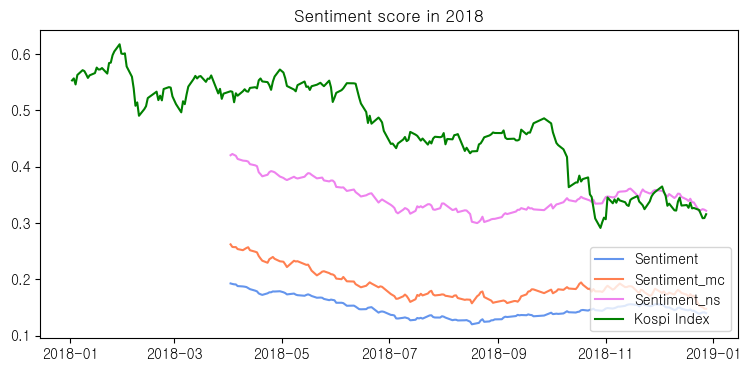

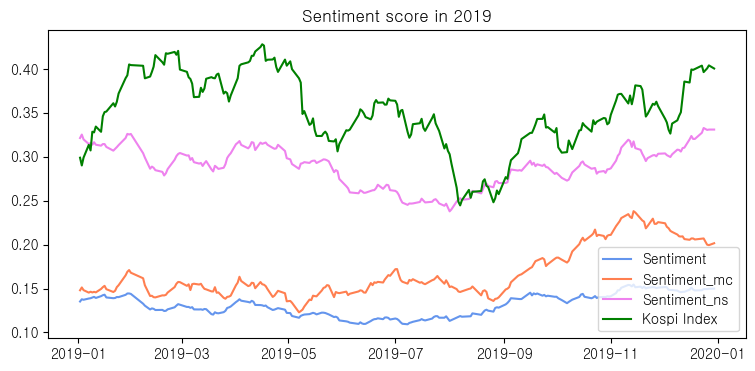

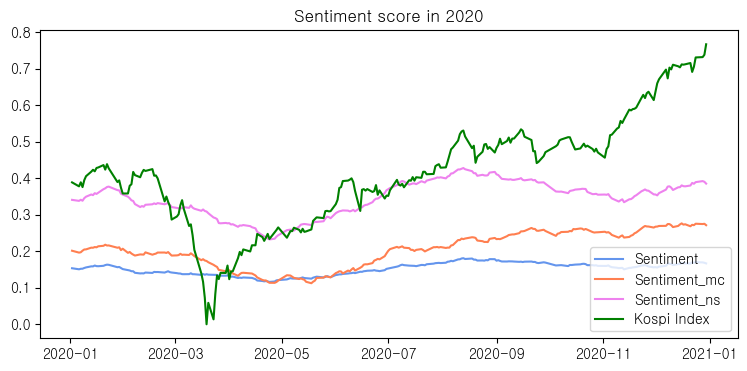

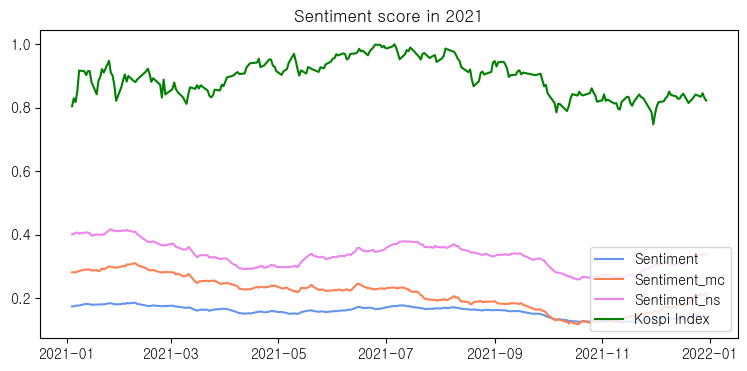

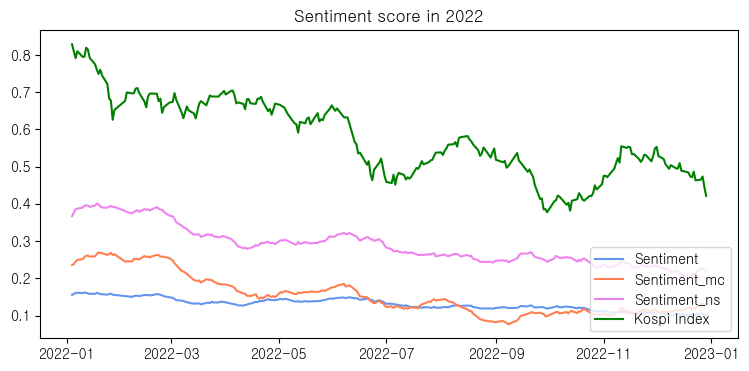

In [ ]:
# 감성수치 시각화

target_y = [2018,2019, 2020, 2021, 2022]

for y in target_y :
    data_y = kospi_group_by.query('일자.dt.year=='+str(y))
    
    plt.figure(figsize=(9,4))
    plt.title('Sentiment score in '+ str(y))
    plt.plot(data_y['일자'], data_y['감성수치_벤치마킹_ma90'], label='Sentiment', c='cornflowerblue')
    plt.plot(data_y['일자'], data_y['감성수치_mc_ma90'], label='Sentiment_mc', c='coral')
    plt.plot(data_y['일자'], data_y['감성수치_ns_ma90'], label='Sentiment_ns', c='violet')
    plt.plot(data_y['일자'], data_y['kospi'], label='Kospi Index', c='green')
    plt.legend(loc='lower right')
    plt.show()
    

# - 감성분석의 각 결과 (가중치 별 3가지)와 코스피 흐름의 상관성 확인

In [397]:
''' kospi_group_by
kospi_group_by['kospi_등락률'] = kospi_group_by['kospi'].pct_change() '''

In [104]:
kospi_group_by['선정종목평균가'] = df.iloc[:,1::2].sum(axis = 1) / 30

In [448]:
kospi_group_by.columns

Index(['일자', '감성수치_벤치마킹', '반응도_벤치마킹', '감성수치_mc', '반응도_mc', '감성수치_ns', '반응도_ns',
       '감성수치_벤치마킹_ma7', '감성수치_벤치마킹_ma15', '감성수치_벤치마킹_ma30', '감성수치_벤치마킹_ma90',
       '감성수치_mc_ma7', '감성수치_mc_ma15', '감성수치_mc_ma30', '감성수치_mc_ma90',
       '감성수치_ns_ma7', '감성수치_ns_ma15', '감성수치_ns_ma30', '감성수치_ns_ma90',
       '반응도_벤치마킹_ma7', '반응도_벤치마킹_ma15', '반응도_벤치마킹_ma30', '반응도_벤치마킹_ma90',
       '반응도_mc_ma7', '반응도_mc_ma15', '반응도_mc_ma30', '반응도_mc_ma90', '반응도_ns_ma7',
       '반응도_ns_ma15', '반응도_ns_ma30', '반응도_ns_ma90', '감성+반응', '감성+반응_벤치마킹_ma7',
       '감성+반응_벤치마킹_ma15', '감성+반응_벤치마킹_ma30', '감성+반응_벤치마킹_ma90', '감성+반응_mc',
       '감성+반응_mc_ma7', '감성+반응_mc_ma15', '감성+반응_mc_ma30', '감성+반응_mc_ma90',
       '감성+반응_ns', '감성+반응_ns_ma7', '감성+반응_ns_ma15', '감성+반응_ns_ma30',
       '감성+반응_ns_ma90'],
      dtype='object')

In [454]:
corr = kospi_group_by.iloc[:,1:].corr(method = 'pearson')
corr

,kospi,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc,감성수치_ns,반응도_ns,감성수치_벤치마킹_ma7,감성수치_벤치마킹_ma15,감성수치_벤치마킹_ma30,...,감성+반응_mc,감성+반응_mc_ma7,감성+반응_mc_ma15,감성+반응_mc_ma30,감성+반응_mc_ma90,감성+반응_ns,감성+반응_ns_ma7,감성+반응_ns_ma15,감성+반응_ns_ma30,감성+반응_ns_ma90
kospi,1.000000,0.066193,0.005538,0.087419,0.063982,0.044802,0.036571,0.215459,0.265552,0.345486,...,0.102801,0.239219,0.291535,0.377122,0.502534,0.075606,0.212348,0.243776,0.316273,0.390983
감성수치_벤치마킹,0.066193,1.000000,0.606827,0.664084,0.468800,0.846760,0.533670,0.428079,0.348646,0.265828,...,0.690376,0.311323,0.271004,0.219091,0.132701,0.870355,0.355373,0.301894,0.231344,0.133257
반응도_벤치마킹,0.005538,0.606827,1.000000,0.346255,0.793738,0.377317,0.855139,0.166050,0.115428,0.076318,...,0.459669,0.163409,0.121621,0.085315,0.046164,0.508662,0.138815,0.116776,0.085514,0.060997
감성수치_mc,0.087419,0.664084,0.346255,1.000000,0.360187,0.708672,0.350168,0.337300,0.299474,0.226649,...,0.967706,0.477397,0.405224,0.303826,0.191804,0.698527,0.344545,0.310355,0.228265,0.164280
반응도_mc,0.063982,0.468800,0.793738,0.360187,1.000000,0.327376,0.811520,0.121224,0.076609,0.048343,...,0.475680,0.186243,0.131417,0.081212,0.050244,0.445327,0.118284,0.079561,0.061051,0.036340
감성수치_ns,0.044802,0.846760,0.377317,0.708672,0.327376,1.000000,0.441190,0.391986,0.341050,0.259429,...,0.673559,0.327999,0.287044,0.225305,0.133127,0.963398,0.430682,0.360310,0.273691,0.164487
반응도_ns,0.036571,0.533670,0.855139,0.350168,0.811520,0.441190,1.000000,0.136081,0.111149,0.080490,...,0.416611,0.153382,0.126305,0.093177,0.066195,0.556935,0.171509,0.139558,0.103695,0.067547
감성수치_벤치마킹_ma7,0.215459,0.428079,0.166050,0.337300,0.121224,0.391986,0.136081,1.000000,0.785064,0.609935,...,0.340302,0.694326,0.556424,0.458109,0.335142,0.400749,0.868893,0.683811,0.527416,0.332164
감성수치_벤치마킹_ma15,0.265552,0.348646,0.115428,0.299474,0.076609,0.341050,0.111149,0.785064,1.000000,0.793233,...,0.294217,0.578567,0.715825,0.588361,0.442949,0.347977,0.689719,0.883611,0.689113,0.438292
감성수치_벤치마킹_ma30,0.345486,0.265828,0.076318,0.226649,0.048343,0.259429,0.080490,0.609935,0.793233,1.000000,...,0.221246,0.445035,0.584715,0.737044,0.582958,0.267870,0.568002,0.738046,0.903978,0.595544


# cross correlation with two time series in python

In [1132]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    wrap : NaN 채우는 것. shift 하면서 사라진 값으로 다시 채우기. 값이 순환되게 된다. wrap=False 이면 NaN은 drop하고 correlation 구한다.
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

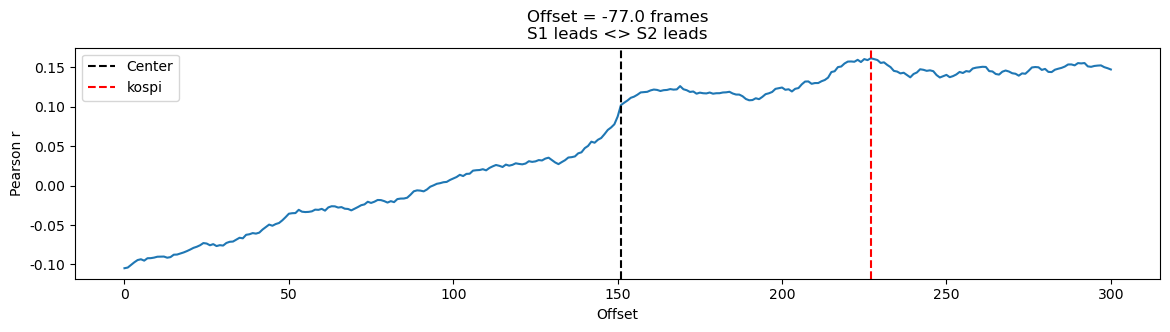

In [1147]:
d1 = kospi_group_by['kospi']
d2 = kospi_group_by['감성수치_mc']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
offset = np.floor(len(rs)/2)-np.argmax(rs) # 최대 correlation 값 가지는 offset 계산 (빨간색)

f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='kospi')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads', xlabel='Offset',ylabel='Pearson r')
plt.legend()

# Offset이 왼쪽에 있으면, S1이 리드하과 S2가 따라오는 것
# shift(-150)이 d2에 대해서 적용되고, d2의 미래와 d1의 현재간에 correlation 계산 하는 것. 즉, offset이 음수이면 d1이 선행한다는 뜻
# 이것도 결국 global level로 correlation 측정하는 것. 시차 두면서.

In [1174]:
import scipy.stats as stats

overall_pearson_r = kospi_group_by[['kospi','감성수치_mc_ma90']].corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r}")
# out: Pandas computed Pearson r: 0.2058774513561943

r, p = stats.pearsonr(kospi_group_by.dropna()['kospi'], kospi_group_by.dropna()['감성수치_mc_ma90'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Pandas computed Pearson r: 0.4416622170252528
Scipy computed Pearson r: 0.4416622170252511 and p-value: 1.9393195613208093e-54


# 뉴스 감성분석 기반 종가 예측 비교

In [9]:
df_kospi200 = fdr.DataReader('KS11', kospi_group_by['일자'].iloc[0], kospi_group_by['일자'].iloc[-1])
df_kospi200 = df_kospi200.reset_index()
df_kospi200 = pd.DataFrame(df_kospi200[['Date', 'Open', 'High', 'Low','Close','Volume']])
df_kospi200.columns = ['일자', 'open', 'high', 'low','close','volume']
df_kospi200.일자 = df_kospi200.일자.astype(str)

In [10]:
# 감성수치
data_set = pd.merge(df_kospi200, kospi_group_by[['일자','감성수치_벤치마킹', '감성수치_mc', '감성수치_ns',
                                                 '감성수치_벤치마킹_ma7', '감성수치_벤치마킹_ma15', '감성수치_벤치마킹_ma30','감성수치_벤치마킹_ma90', 
                                                 '감성수치_mc_ma7', '감성수치_mc_ma15', '감성수치_mc_ma30','감성수치_mc_ma90', 
                                                 '감성수치_ns_ma7', '감성수치_ns_ma15', '감성수치_ns_ma30','감성수치_ns_ma90']], on = '일자', how = 'inner')
# data_set = data_set.iloc[:,1:]
# df = data_set.set_index('일자').sort_index()
d_set = pd.DataFrame(data_set, columns= ['open', 'high', 'low','close','volume',
                                         '감성수치_벤치마킹', '감성수치_mc', '감성수치_ns',
                                         '감성수치_벤치마킹_ma7', '감성수치_벤치마킹_ma15', '감성수치_벤치마킹_ma30','감성수치_벤치마킹_ma90',
                                         '감성수치_mc_ma7', '감성수치_mc_ma15', '감성수치_mc_ma30','감성수치_mc_ma90', 
                                         '감성수치_ns_ma7', '감성수치_ns_ma15', '감성수치_ns_ma30','감성수치_ns_ma90'])
data_set

,일자,open,high,low,close,volume,감성수치_벤치마킹,감성수치_mc,감성수치_ns,감성수치_벤치마킹_ma7,...,감성수치_벤치마킹_ma30,감성수치_벤치마킹_ma90,감성수치_mc_ma7,감성수치_mc_ma15,감성수치_mc_ma30,감성수치_mc_ma90,감성수치_ns_ma7,감성수치_ns_ma15,감성수치_ns_ma30,감성수치_ns_ma90
0,2018-01-02,2474.860107,2481.020020,2465.939941,2479.649902,262200,0.233062,0.299675,0.516725,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,2484.629883,2493.399902,2481.909912,2486.350098,331100,0.261299,0.316113,0.499264,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,2502.500000,2502.500000,2466.449951,2466.459961,333800,0.263362,0.245495,0.502335,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,2476.850098,2497.520020,2475.510010,2497.520020,308800,0.134983,0.395336,0.251100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,2510.699951,2515.370117,2494.179932,2513.280029,311400,0.313781,0.297832,0.458035,0.237712,...,NaN,NaN,0.283034,NaN,NaN,NaN,0.483161,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,2022-12-23,2325.860107,2333.080078,2311.899902,2313.689941,367000,0.001374,0.076290,0.095221,0.113679,...,0.104388,0.101512,0.138892,0.093926,0.078946,0.119699,0.317427,0.165758,0.219918,0.212917
1170,2022-12-26,2312.540039,2321.919922,2304.199951,2317.139893,427600,0.230973,0.453322,0.616255,0.143952,...,0.110610,0.104929,0.205371,0.176471,0.121266,0.131568,0.373792,0.250859,0.240664,0.226635
1171,2022-12-27,2327.520020,2335.989990,2321.479980,2332.790039,448300,0.139742,-0.082128,0.231569,0.127123,...,0.112402,0.105139,0.180946,0.165429,0.123437,0.132333,0.339678,0.258868,0.238111,0.226136
1172,2022-12-28,2296.449951,2296.449951,2276.899902,2280.449951,405700,0.040738,-0.299554,0.088894,0.109159,...,0.111143,0.102944,0.111314,0.142424,0.106709,0.126380,0.295180,0.256069,0.232801,0.223031


In [11]:
# 반응도
data_set = pd.merge(df_kospi200, kospi_group_by[['일자','반응도_벤치마킹', '반응도_mc', '반응도_ns',
                                                 '반응도_벤치마킹_ma7', '반응도_벤치마킹_ma15', '반응도_벤치마킹_ma30','반응도_벤치마킹_ma90', 
                                                 '반응도_mc_ma7', '반응도_mc_ma15', '반응도_mc_ma30','반응도_mc_ma90', 
                                                 '반응도_ns_ma7', '반응도_ns_ma15', '반응도_ns_ma30','반응도_ns_ma90']], on = '일자', how = 'inner')
# data_set = data_set.iloc[:,1:]
# df = data_set.set_index('일자').sort_index()
d_set = pd.DataFrame(data_set, columns= ['open', 'high', 'low','close','volume',
                                         '반응도_벤치마킹', '반응도_mc', '반응도_ns',
                                         '반응도_벤치마킹_ma7', '반응도_벤치마킹_ma15', '반응도_벤치마킹_ma30','반응도_벤치마킹_ma90',
                                         '반응도_mc_ma7', '반응도_mc_ma15', '반응도_mc_ma30','반응도_mc_ma90', 
                                         '반응도_ns_ma7', '반응도_ns_ma15', '반응도_ns_ma30','반응도_ns_ma90'])
data_set

,일자,open,high,low,close,volume,반응도_벤치마킹,반응도_mc,반응도_ns,반응도_벤치마킹_ma7,...,반응도_벤치마킹_ma30,반응도_벤치마킹_ma90,반응도_mc_ma7,반응도_mc_ma15,반응도_mc_ma30,반응도_mc_ma90,반응도_ns_ma7,반응도_ns_ma15,반응도_ns_ma30,반응도_ns_ma90
0,2018-01-02,2474.860107,2481.020020,2465.939941,2479.649902,262200,0.291153,0.492771,0.732833,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,2484.629883,2493.399902,2481.909912,2486.350098,331100,0.389296,0.587614,0.832532,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,2502.500000,2502.500000,2466.449951,2466.459961,333800,0.336615,0.500091,0.764084,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,2476.850098,2497.520020,2475.510010,2497.520020,308800,0.290466,0.469101,0.674223,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,2510.699951,2515.370117,2494.179932,2513.280029,311400,0.480487,0.556660,0.801711,0.326258,...,NaN,NaN,0.456501,NaN,NaN,NaN,0.729787,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,2022-12-23,2325.860107,2333.080078,2311.899902,2313.689941,367000,0.155372,0.397016,0.609045,0.250163,...,0.248531,0.266987,0.472287,0.455107,0.427226,0.430481,0.695822,0.664110,0.648364,0.630726
1170,2022-12-26,2312.540039,2321.919922,2304.199951,2317.139893,427600,0.230973,0.453322,0.616255,0.231072,...,0.252373,0.264331,0.439674,0.474913,0.442697,0.430765,0.642881,0.682834,0.658773,0.627186
1171,2022-12-27,2327.520020,2335.989990,2321.479980,2332.790039,448300,0.385100,0.499488,0.767064,0.241678,...,0.259942,0.265809,0.443620,0.468907,0.446913,0.431212,0.655143,0.680629,0.663922,0.627912
1172,2022-12-28,2296.449951,2296.449951,2276.899902,2280.449951,405700,0.195384,0.382786,0.563461,0.228729,...,0.259840,0.263350,0.421352,0.467291,0.445454,0.429142,0.634305,0.672790,0.660730,0.625180


In [13]:
# 감성수치 + 반응도
data_set = pd.merge(df_kospi200, kospi_group_by[['일자','감성수치_벤치마킹', '반응도_벤치마킹', '감성수치_mc', '반응도_mc', '감성수치_ns',
       '반응도_ns', '감성수치_벤치마킹_ma7', '감성수치_벤치마킹_ma15', '감성수치_벤치마킹_ma30',
       '감성수치_벤치마킹_ma90', '감성수치_mc_ma7', '감성수치_mc_ma15', '감성수치_mc_ma30',
       '감성수치_mc_ma90', '감성수치_ns_ma7', '감성수치_ns_ma15', '감성수치_ns_ma30',
       '감성수치_ns_ma90', '반응도_벤치마킹_ma7', '반응도_벤치마킹_ma15', '반응도_벤치마킹_ma30',
       '반응도_벤치마킹_ma90', '반응도_mc_ma7', '반응도_mc_ma15', '반응도_mc_ma30',
       '반응도_mc_ma90', '반응도_ns_ma7', '반응도_ns_ma15', '반응도_ns_ma30','반응도_ns_ma90']], on = '일자', how = 'inner')
# data_set = data_set.iloc[:,1:]
# df = data_set.set_index('일자').sort_index()
d_set = pd.DataFrame(data_set, columns= ['open', 'high', 'low','close','volume',
                                         '감성수치_벤치마킹', '반응도_벤치마킹', '감성수치_mc', '반응도_mc', '감성수치_ns',
                                         '반응도_ns', '감성수치_벤치마킹_ma7', '감성수치_벤치마킹_ma15', '감성수치_벤치마킹_ma30',
                                         '감성수치_벤치마킹_ma90', '감성수치_mc_ma7', '감성수치_mc_ma15', '감성수치_mc_ma30',
                                         '감성수치_mc_ma90', '감성수치_ns_ma7', '감성수치_ns_ma15', '감성수치_ns_ma30',
                                         '감성수치_ns_ma90', '반응도_벤치마킹_ma7', '반응도_벤치마킹_ma15', '반응도_벤치마킹_ma30',
                                         '반응도_벤치마킹_ma90', '반응도_mc_ma7', '반응도_mc_ma15', '반응도_mc_ma30',
                                         '반응도_mc_ma90', '반응도_ns_ma7', '반응도_ns_ma15', '반응도_ns_ma30','반응도_ns_ma90'])
data_set

,일자,open,high,low,close,volume,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc,...,반응도_벤치마킹_ma30,반응도_벤치마킹_ma90,반응도_mc_ma7,반응도_mc_ma15,반응도_mc_ma30,반응도_mc_ma90,반응도_ns_ma7,반응도_ns_ma15,반응도_ns_ma30,반응도_ns_ma90
0,2018-01-02,2474.860107,2481.020020,2465.939941,2479.649902,262200,0.233062,0.291153,0.299675,0.492771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-03,2484.629883,2493.399902,2481.909912,2486.350098,331100,0.261299,0.389296,0.316113,0.587614,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-04,2502.500000,2502.500000,2466.449951,2466.459961,333800,0.263362,0.336615,0.245495,0.500091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-05,2476.850098,2497.520020,2475.510010,2497.520020,308800,0.134983,0.290466,0.395336,0.469101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-08,2510.699951,2515.370117,2494.179932,2513.280029,311400,0.313781,0.480487,0.297832,0.556660,...,NaN,NaN,0.456501,NaN,NaN,NaN,0.729787,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,2022-12-23,2325.860107,2333.080078,2311.899902,2313.689941,367000,0.001374,0.155372,0.076290,0.397016,...,0.248531,0.266987,0.472287,0.455107,0.427226,0.430481,0.695822,0.664110,0.648364,0.630726
1170,2022-12-26,2312.540039,2321.919922,2304.199951,2317.139893,427600,0.230973,0.230973,0.453322,0.453322,...,0.252373,0.264331,0.439674,0.474913,0.442697,0.430765,0.642881,0.682834,0.658773,0.627186
1171,2022-12-27,2327.520020,2335.989990,2321.479980,2332.790039,448300,0.139742,0.385100,-0.082128,0.499488,...,0.259942,0.265809,0.443620,0.468907,0.446913,0.431212,0.655143,0.680629,0.663922,0.627912
1172,2022-12-28,2296.449951,2296.449951,2276.899902,2280.449951,405700,0.040738,0.195384,-0.299554,0.382786,...,0.259840,0.263350,0.421352,0.467291,0.445454,0.429142,0.634305,0.672790,0.660730,0.625180


In [ ]:
# 감성수치 * 반응도
data_set = pd.merge(df_kospi200, kospi_group_by[['일자','감성+반응', 
                                                 '감성+반응_벤치마킹_ma7','감성+반응_벤치마킹_ma15', '감성+반응_벤치마킹_ma30', '감성+반응_벤치마킹_ma90', 
                                                 '감성+반응_mc','감성+반응_mc_ma7', '감성+반응_mc_ma15', '감성+반응_mc_ma30', '감성+반응_mc_ma90',
                                                 '감성+반응_ns', '감성+반응_ns_ma7', '감성+반응_ns_ma15', '감성+반응_ns_ma30','감성+반응_ns_ma90']], on = '일자', how = 'inner')
# data_set = data_set.iloc[:,1:]
# df = data_set.set_index('일자').sort_index()
d_set = pd.DataFrame(data_set, columns= ['open', 'high', 'low','close','volume','감성+반응', 
                                                 '감성+반응_벤치마킹_ma7','감성+반응_벤치마킹_ma15', '감성+반응_벤치마킹_ma30', '감성+반응_벤치마킹_ma90', 
                                                 '감성+반응_mc','감성+반응_mc_ma7', '감성+반응_mc_ma15', '감성+반응_mc_ma30', '감성+반응_mc_ma90',
                                                 '감성+반응_ns', '감성+반응_ns_ma7', '감성+반응_ns_ma15', '감성+반응_ns_ma30','감성+반응_ns_ma90'])
data_set

,일자,open,high,low,close,volume,감성+반응,감성+반응_벤치마킹_ma7,감성+반응_벤치마킹_ma15,감성+반응_벤치마킹_ma30,...,감성+반응_mc,감성+반응_mc_ma7,감성+반응_mc_ma15,감성+반응_mc_ma30,감성+반응_mc_ma90,감성+반응_ns,감성+반응_ns_ma7,감성+반응_ns_ma15,감성+반응_ns_ma30,감성+반응_ns_ma90
0,2018-01-02,2474.860107,2481.020020,2465.939941,2479.649902,262200,0.067857,NaN,NaN,NaN,...,0.147671,NaN,NaN,NaN,NaN,0.378673,NaN,NaN,NaN,NaN
1,2018-01-03,2484.629883,2493.399902,2481.909912,2486.350098,331100,0.101723,NaN,NaN,NaN,...,0.185753,NaN,NaN,NaN,NaN,0.415653,NaN,NaN,NaN,NaN
2,2018-01-04,2502.500000,2502.500000,2466.449951,2466.459961,333800,0.088652,NaN,NaN,NaN,...,0.122770,NaN,NaN,NaN,NaN,0.383826,NaN,NaN,NaN,NaN
3,2018-01-05,2476.850098,2497.520020,2475.510010,2497.520020,308800,0.039208,NaN,NaN,NaN,...,0.185453,NaN,NaN,NaN,NaN,0.169297,NaN,NaN,NaN,NaN
4,2018-01-08,2510.699951,2515.370117,2494.179932,2513.280029,311400,0.150768,0.077555,NaN,NaN,...,0.165791,0.129205,NaN,NaN,NaN,0.367212,0.352605,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,2022-12-23,2325.860107,2333.080078,2311.899902,2313.689941,367000,0.000213,0.028438,0.023523,0.025944,...,0.030288,0.065597,0.042746,0.033728,0.051528,0.057994,0.220873,0.110081,0.142587,0.134293
1170,2022-12-26,2312.540039,2321.919922,2304.199951,2317.139893,427600,0.053348,0.033263,0.030648,0.027915,...,0.205501,0.090296,0.083808,0.053684,0.056675,0.379770,0.240304,0.171295,0.158543,0.142143
1171,2022-12-27,2327.520020,2335.989990,2321.479980,2332.790039,448300,0.053815,0.030723,0.031716,0.029218,...,-0.041022,0.080271,0.077571,0.055166,0.057064,0.177629,0.222538,0.176193,0.158087,0.141994
1172,2022-12-28,2296.449951,2296.449951,2276.899902,2280.449951,405700,0.007960,0.024968,0.029350,0.028879,...,-0.114665,0.046902,0.066554,0.047534,0.054235,0.050088,0.187234,0.172281,0.153819,0.139434


In [14]:
import talib

In [15]:
i = d_set

In [16]:
ADX=talib.ADX(i.high, i.low,i.close,timeperiod=14)

ADXR=talib.ADXR(i.high,i.low,i.close,timeperiod=14)

APO=talib.APO(i.close,fastperiod=12,slowperiod=26,matype=0)

aroondown,aroonup =talib.AROON(i.high, i.low, timeperiod=14)

AROONOSC=talib.AROONOSC(i.high,i.low,timeperiod=14)

BOP=talib.BOP(i.open,i.high,i.low,i.close)

CCI=talib.CCI(i.high,i.low,i.close,timeperiod=14)

CMO=talib.CMO(i.close,timeperiod=14)

DX=talib.DX(i.high,i.low,i.close,timeperiod=14)

macd, macdsignal, macdhist = talib.MACD(i.close, fastperiod=12, slowperiod=26, signalperiod=9)

ma_macd, ma_macdsignal, ma_macdhist = talib.MACDEXT(i.close, fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)

fix_macd,fix_macdsignal, fix_macdhist = talib.MACDFIX(i.close, signalperiod=9)

MFI=talib.MFI(i.high, i.low,i.close, i.volume, timeperiod=14)

MINUS_DI=talib.MINUS_DI(i.high, i.low, i.close, timeperiod=14)

MINUS_DM=talib. MINUS_DM(i.high, i.low, timeperiod=14)

MOM=talib.MOM(i.close,timeperiod=10)

PLUS_DM=talib.PLUS_DM(i.high,i.low,timeperiod=14)

PPO=talib.PPO(i.close, fastperiod=12, slowperiod=26, matype=0)

ROC=talib.ROC(i.close,timeperiod=10)

ROCP=talib.ROCP(i.close,timeperiod=10)

ROCR=talib.ROCR(i.close,timeperiod=10)

ROCR100=talib.ROCR100(i.close,timeperiod=10)

RSI=talib.RSI(i.close,timeperiod=14)

slowk, slowd = talib.STOCH(i.high, i.low, i.close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)

fastk, fastd = talib.STOCHF(i.high, i.low, i.close, fastk_period=5, fastd_period=3, fastd_matype=0)

TRIX=talib.TRIX(i.close,timeperiod=72)

ULTOSC=talib.ULTOSC(i.high,i.low,i.close,timeperiod1=7,timeperiod2=14,timeperiod3=28)

WILLR=talib.WILLR(i.high,i.low,i.close,timeperiod=14)


i['ADX']=ADX
i['ADXR']=ADXR
i['APO']=APO
i['aroondown']=aroondown
i['aroonup']=aroonup
i['AROONOSC']=AROONOSC
i['BOP']=BOP
i['CCI']=CCI
i['CMO']=CMO
i['DX']=DX
i['MACD']=macd
i['macdsignal']=macdsignal
i['macdhist']=macdhist
i['ma_macd']=ma_macd
i['ma_macdsignal']=ma_macdsignal
i['ma_macdhist']=ma_macdhist
i['fix_macd']=fix_macd
i['fix_macdsignal']=fix_macdsignal
i['fix_macdhist']=fix_macdhist
i['MFI']=MFI
i['MINUS_DI']=MINUS_DI
i['MINUS_DM']=MINUS_DM
i['MOM']=MOM
i['PLUS_DM']=PLUS_DM
i['PPO']=PPO
i['ROC']=ROC
i['ROCP']=ROCP
i['ROCR']=ROCR
i['ROCR100']=ROCR100
i['RSI']=RSI
i['slowk']=slowk
i['slowd']=slowd
i['fastk']=fastk
i['fastd']=fastd
i['TRIX']=TRIX
i['ULTOSC']=ULTOSC
i['WILLR']=WILLR

In [17]:
d_set = i

In [18]:
d_set

,open,high,low,close,volume,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc,감성수치_ns,...,ROCR,ROCR100,RSI,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR
0,2474.860107,2481.020020,2465.939941,2479.649902,262200,0.233062,0.291153,0.299675,0.492771,0.516725,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2484.629883,2493.399902,2481.909912,2486.350098,331100,0.261299,0.389296,0.316113,0.587614,0.499264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2502.500000,2502.500000,2466.449951,2466.459961,333800,0.263362,0.336615,0.245495,0.500091,0.502335,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2476.850098,2497.520020,2475.510010,2497.520020,308800,0.134983,0.290466,0.395336,0.469101,0.251100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2510.699951,2515.370117,2494.179932,2513.280029,311400,0.313781,0.480487,0.297832,0.556660,0.458035,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1169,2325.860107,2333.080078,2311.899902,2313.689941,367000,0.001374,0.155372,0.076290,0.397016,0.095221,...,0.968460,96.846009,38.511021,33.270489,28.840559,3.819963,33.270489,-0.080931,41.125475,-98.294876
1170,2312.540039,2321.919922,2304.199951,2317.139893,427600,0.230973,0.230973,0.453322,0.453322,0.616255,...,0.976452,97.645189,39.308988,39.361526,36.146128,24.633419,39.361526,-0.079706,48.376970,-86.518082
1171,2327.520020,2335.989990,2321.479980,2332.790039,448300,0.139742,0.385100,-0.082128,0.499488,0.231569,...,0.983304,98.330388,42.927300,27.626521,33.419512,54.426180,27.626521,-0.078522,46.366727,-70.212447
1172,2296.449951,2296.449951,2276.899902,2280.449951,405700,0.040738,0.195384,-0.299554,0.382786,0.088894,...,0.950485,95.048451,35.339113,27.835535,31.607861,4.447007,27.835535,-0.077423,38.322184,-97.120337


In [19]:
d_set.to_csv('pred_info.csv', index=False, encoding='utf-8-sig')

In [20]:
d_set = d_set.dropna()
d_set = d_set.reset_index()
d_set.drop(['index', 'open','high','low','volume'], axis=1, inplace=True)
d_set

,close,감성수치_벤치마킹,반응도_벤치마킹,감성수치_mc,반응도_mc,감성수치_ns,반응도_ns,감성수치_벤치마킹_ma7,감성수치_벤치마킹_ma15,감성수치_벤치마킹_ma30,...,ROCR,ROCR100,RSI,slowk,slowd,fastk,fastd,TRIX,ULTOSC,WILLR
0,2114.350098,0.132546,0.213398,0.344857,0.442674,0.427221,0.625500,0.163018,0.119833,0.132166,...,1.006565,100.656493,52.627493,76.369335,85.013815,60.891018,76.369335,-0.104709,59.108721,-25.219514
1,2101.310059,0.033408,0.380975,-0.011324,0.565533,0.124159,0.801816,0.143390,0.124946,0.126771,...,1.008994,100.899364,49.292130,61.329750,75.622871,29.380135,61.329750,-0.105231,60.942562,-39.907546
2,2068.689941,0.094971,0.161577,0.306021,0.366412,0.254315,0.511957,0.144685,0.139710,0.122480,...,0.996215,99.621482,42.103589,32.239565,56.646217,6.447541,32.239565,-0.105742,49.732389,-76.650177
3,2075.760010,0.219048,0.219048,0.373090,0.373090,0.671771,0.671771,0.141740,0.150383,0.124824,...,1.002807,100.280686,44.009491,17.339047,36.969454,16.189465,17.339047,-0.106232,47.430317,-68.686596
4,2053.790039,0.220234,0.451324,0.054518,0.624269,0.577129,0.852761,0.100913,0.148716,0.122485,...,0.998207,99.820657,39.642337,11.659390,20.412668,12.341165,11.659390,-0.106719,43.509751,-88.688042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2313.689941,0.001374,0.155372,0.076290,0.397016,0.095221,0.609045,0.113679,0.089967,0.104388,...,0.968460,96.846009,38.511021,33.270489,28.840559,3.819963,33.270489,-0.080931,41.125475,-98.294876
956,2317.139893,0.230973,0.230973,0.453322,0.453322,0.616255,0.616255,0.143952,0.113835,0.110610,...,0.976452,97.645189,39.308988,39.361526,36.146128,24.633419,39.361526,-0.079706,48.376970,-86.518082
957,2332.790039,0.139742,0.385100,-0.082128,0.499488,0.231569,0.767064,0.127123,0.117175,0.112402,...,0.983304,98.330388,42.927300,27.626521,33.419512,54.426180,27.626521,-0.078522,46.366727,-70.212447
958,2280.449951,0.040738,0.195384,-0.299554,0.382786,0.088894,0.563461,0.109159,0.110725,0.111143,...,0.950485,95.048451,35.339113,27.835535,31.607861,4.447007,27.835535,-0.077423,38.322184,-97.120337


# 모멘텀 지표만을 이용

In [21]:
d_set.columns

Index(['close', '감성수치_벤치마킹', '반응도_벤치마킹', '감성수치_mc', '반응도_mc', '감성수치_ns',
       '반응도_ns', '감성수치_벤치마킹_ma7', '감성수치_벤치마킹_ma15', '감성수치_벤치마킹_ma30',
       '감성수치_벤치마킹_ma90', '감성수치_mc_ma7', '감성수치_mc_ma15', '감성수치_mc_ma30',
       '감성수치_mc_ma90', '감성수치_ns_ma7', '감성수치_ns_ma15', '감성수치_ns_ma30',
       '감성수치_ns_ma90', '반응도_벤치마킹_ma7', '반응도_벤치마킹_ma15', '반응도_벤치마킹_ma30',
       '반응도_벤치마킹_ma90', '반응도_mc_ma7', '반응도_mc_ma15', '반응도_mc_ma30',
       '반응도_mc_ma90', '반응도_ns_ma7', '반응도_ns_ma15', '반응도_ns_ma30',
       '반응도_ns_ma90', 'ADX', 'ADXR', 'APO', 'aroondown', 'aroonup', 'AROONOSC',
       'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist', 'ma_macd',
       'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR'],
      dtype='object')

RMSE: 562.480622


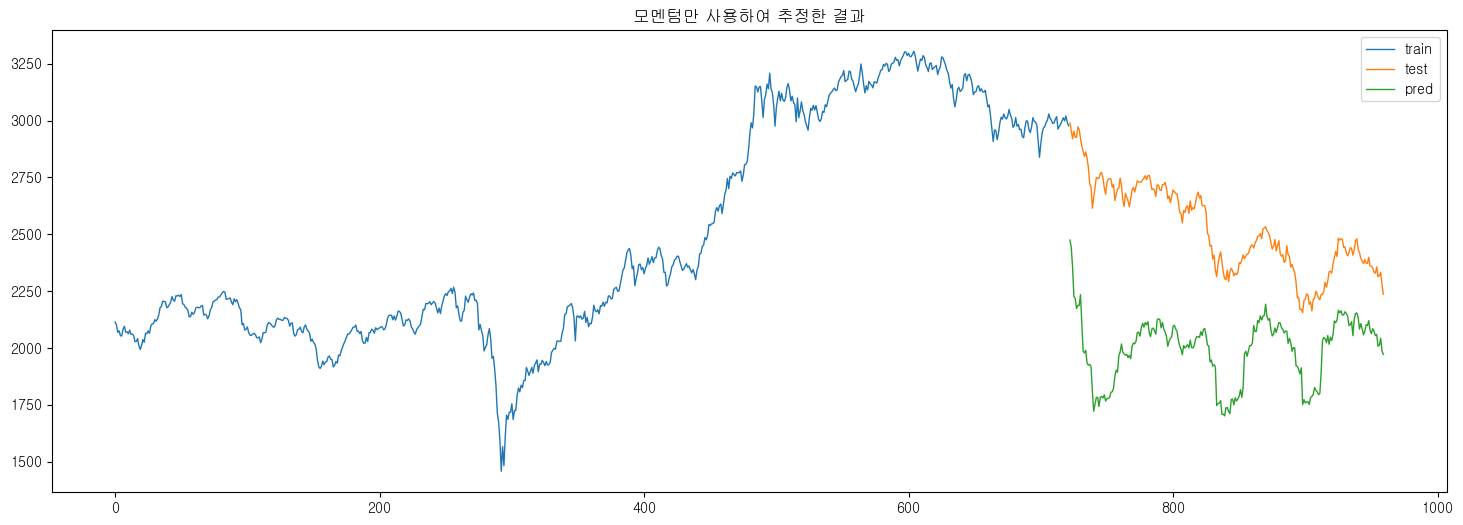

In [22]:
# 모멘텀 지표만을 이용해 코스피 지수 예측하기

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y = d_set.iloc[:,:1]
x = d_set[['ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train = x.iloc[:722,:]
y_train = y.iloc[:722,:]

X_test = x.iloc[722:,:]
y_test = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
y_test['pred'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train.close.plot(ax=ax, label='train', linewidth=1)
y_test.close.plot(ax=ax, label='test', linewidth=1)
y_test.pred.plot(ax=ax, label='pred', linewidth=1)
ax.set_title('모멘텀만 사용하여 추정한 결과')
ax.legend();

# 감성수치 벤치마킹

RMSE: 557.100954
RMSE: 560.988530
RMSE: 561.540991


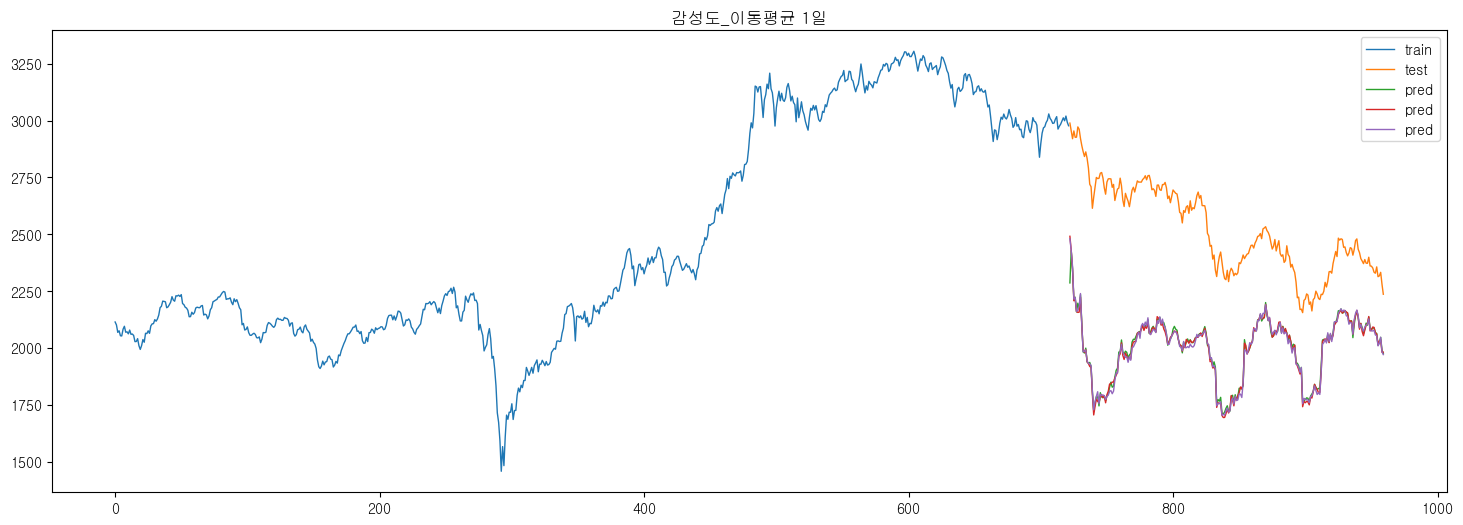

In [57]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성수치_벤치마킹', 'ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_mc','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_ns','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('감성도_이동평균 1일')
ax.legend();

RMSE: 552.631093
RMSE: 554.143597
RMSE: 557.016518


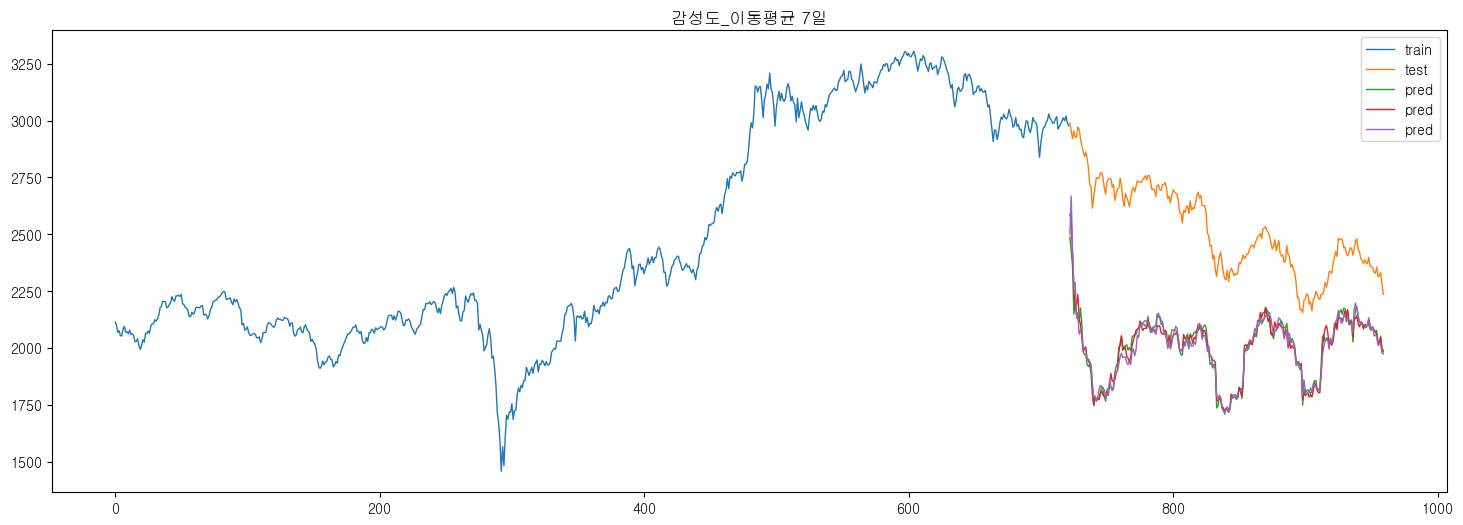

In [58]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성수치_벤치마킹_ma7', 'ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_mc_ma7','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_ns_ma7','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('감성도_이동평균 7일')
ax.legend();

RMSE: 546.812696
RMSE: 569.518051
RMSE: 547.769312


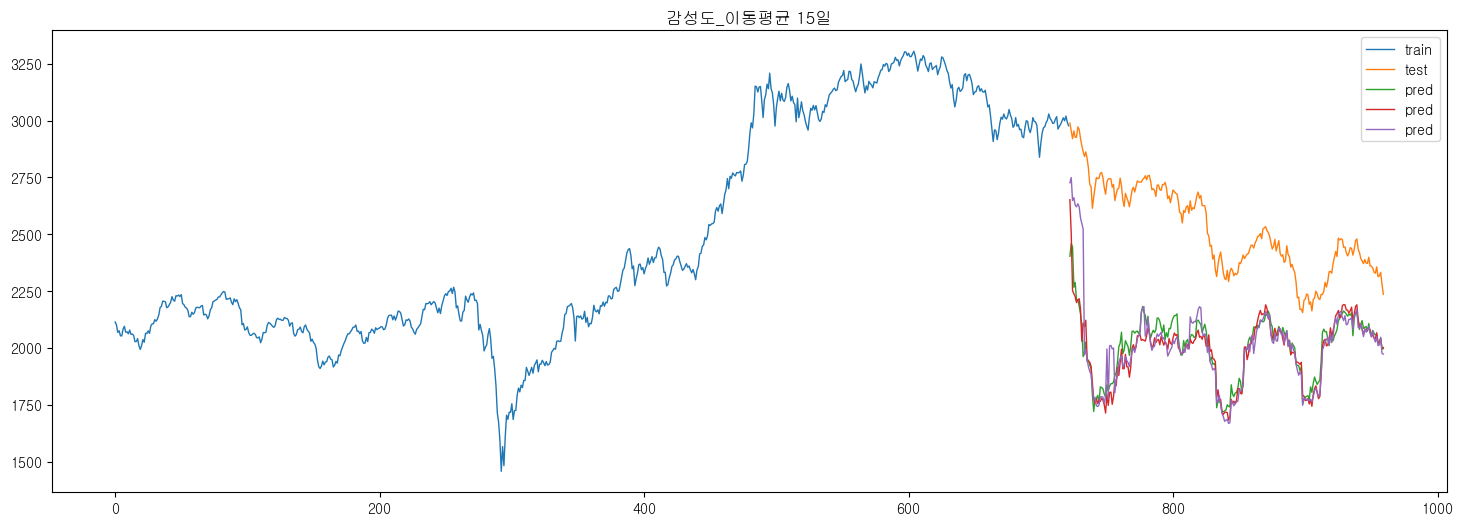

In [59]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성수치_벤치마킹_ma15', 'ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_mc_ma15','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_ns_ma15','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('감성도_이동평균 15일')
ax.legend();

RMSE: 536.951295
RMSE: 551.171426
RMSE: 513.181029


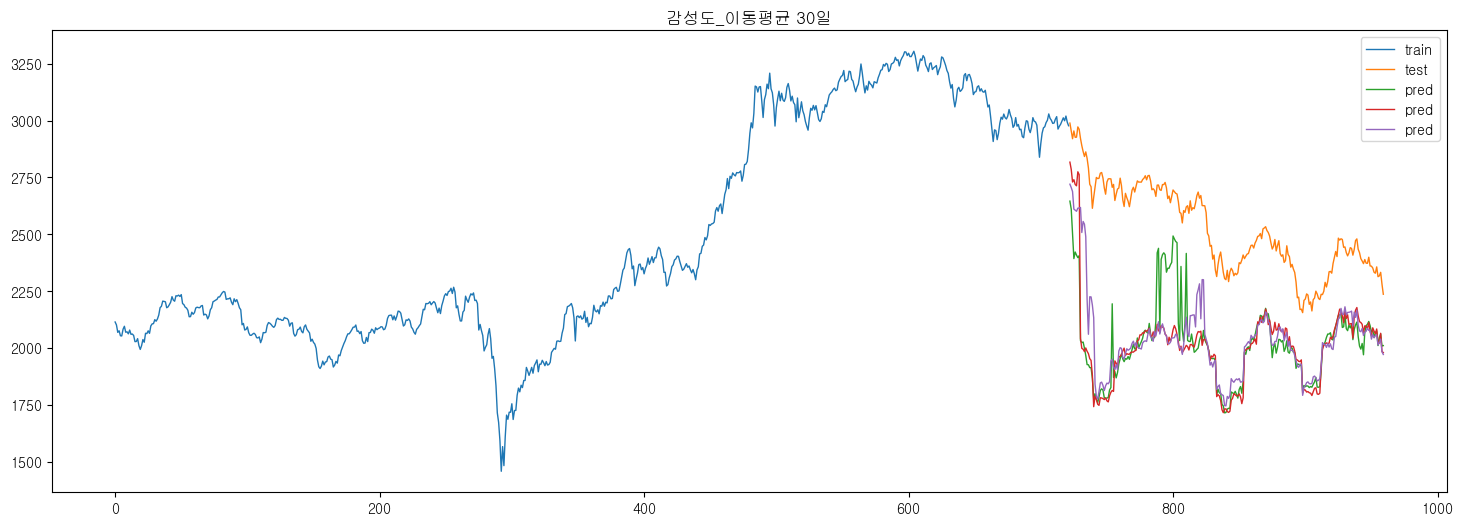

In [60]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성수치_벤치마킹_ma30', 'ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_mc_ma30','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_ns_ma30','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('감성도_이동평균 30일')
ax.legend();

RMSE: 550.621417
RMSE: 580.487342
RMSE: 555.586104


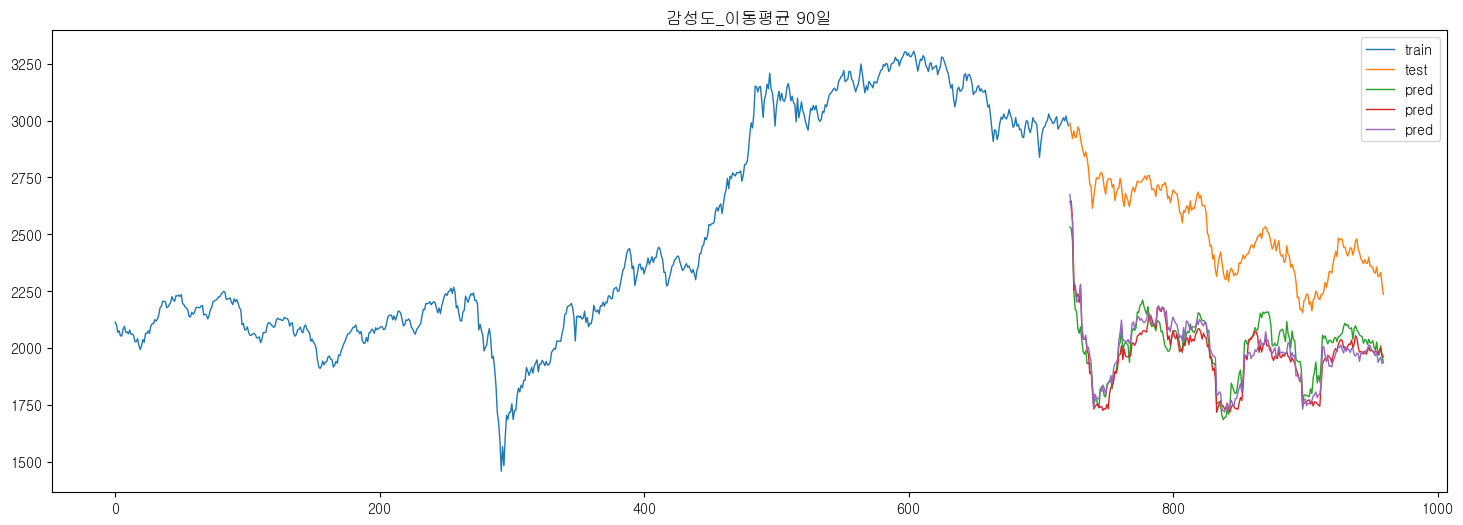

In [61]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성수치_벤치마킹_ma90', 'ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_mc_ma90','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_ns_ma90','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('감성도_이동평균 90일')
ax.legend();

# 반응도 벤치마킹

RMSE: 562.513370
RMSE: 565.935812
RMSE: 562.097265


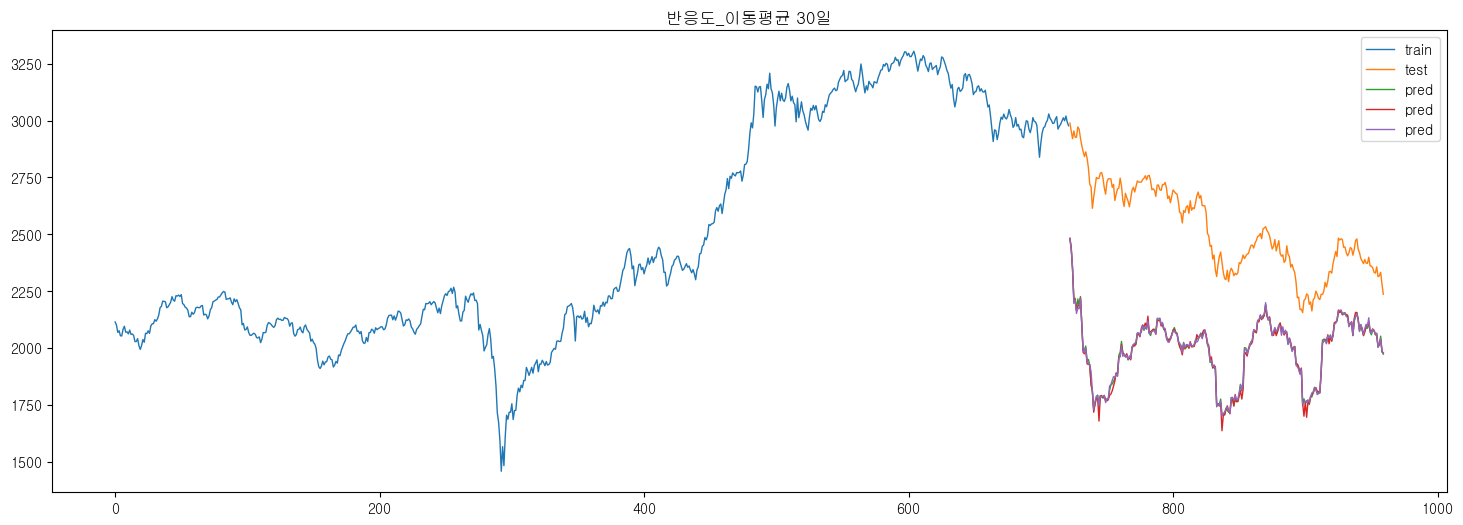

In [71]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['반응도_벤치마킹', 'ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['반응도_mc','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['반응도_ns','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('반응도_이동평균 30일')
ax.legend();

RMSE: 561.229600
RMSE: 558.806277
RMSE: 570.304399


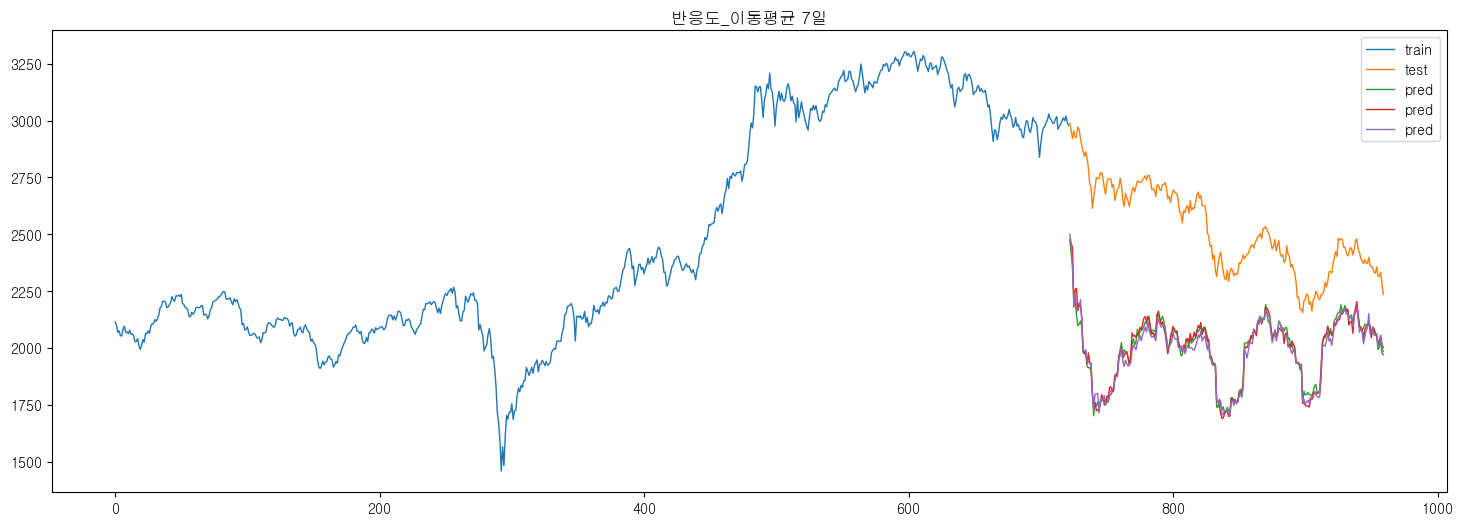

In [72]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['반응도_벤치마킹_ma7', 'ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['반응도_mc_ma7','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['반응도_ns_ma7','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('반응도_이동평균 7일')
ax.legend();

RMSE: 560.627854
RMSE: 568.526733
RMSE: 571.399043


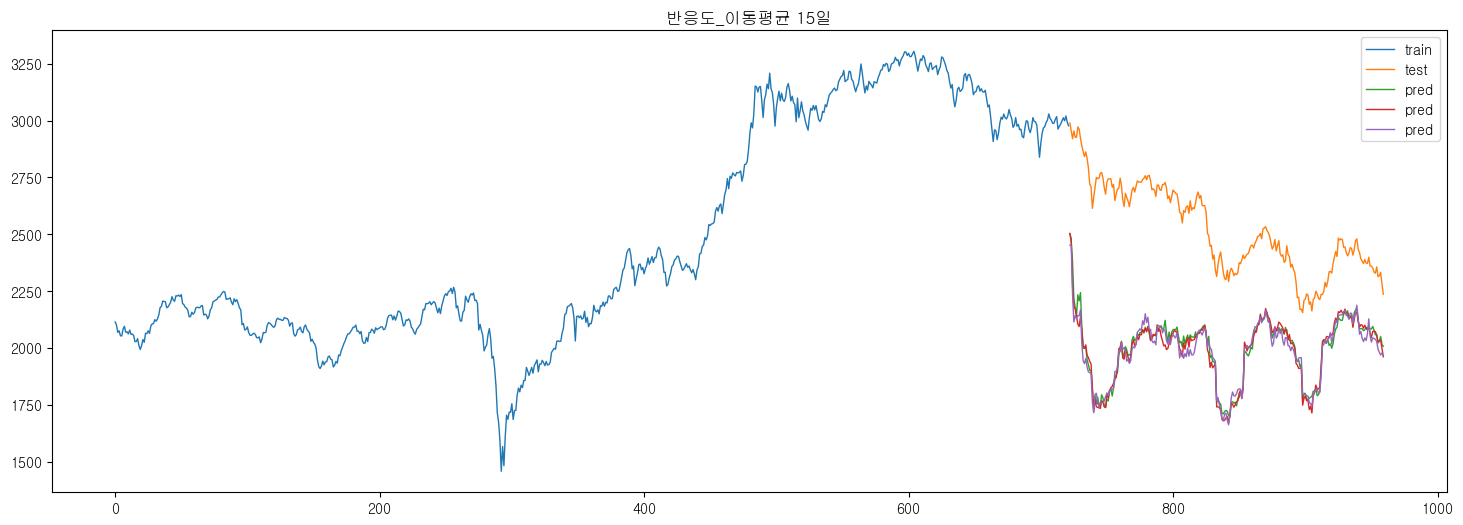

In [74]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['반응도_벤치마킹_ma15', 'ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['반응도_mc_ma15','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['반응도_ns_ma15','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('반응도_이동평균 15일')
ax.legend();

RMSE: 559.589603
RMSE: 516.741476
RMSE: 548.741361


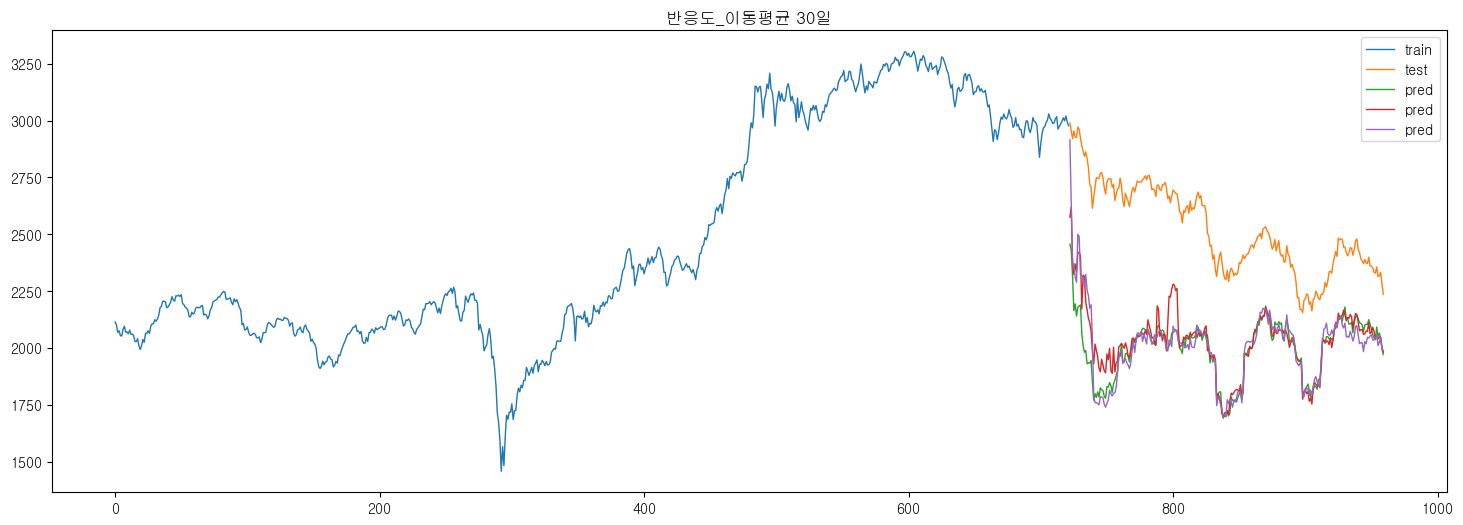

In [75]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['반응도_벤치마킹_ma30', 'ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['반응도_mc_ma30','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['반응도_ns_ma30','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('반응도_이동평균 30일')
ax.legend();

RMSE: 553.014190
RMSE: 271.007369
RMSE: 400.995387


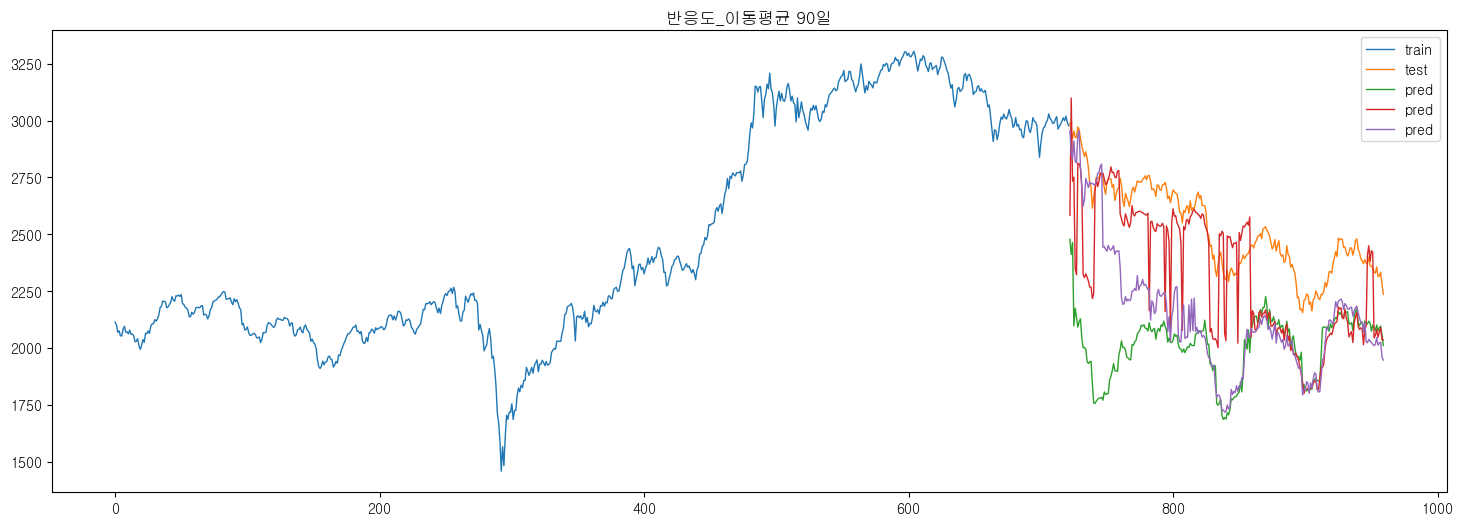

In [77]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['반응도_벤치마킹_ma90', 'ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['반응도_mc_ma90','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['반응도_ns_ma90','ADX', 'ADXR', 'APO',
       'aroondown', 'aroonup', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD',
       'macdsignal', 'macdhist', 'ma_macd', 'ma_macdsignal', 'ma_macdhist',
       'fix_macd', 'fix_macdsignal', 'fix_macdhist', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100',
       'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('반응도_이동평균 90일')
ax.legend();

# 감성수치 + 반응도

RMSE: 557.676828
RMSE: 563.814123
RMSE: 561.168242


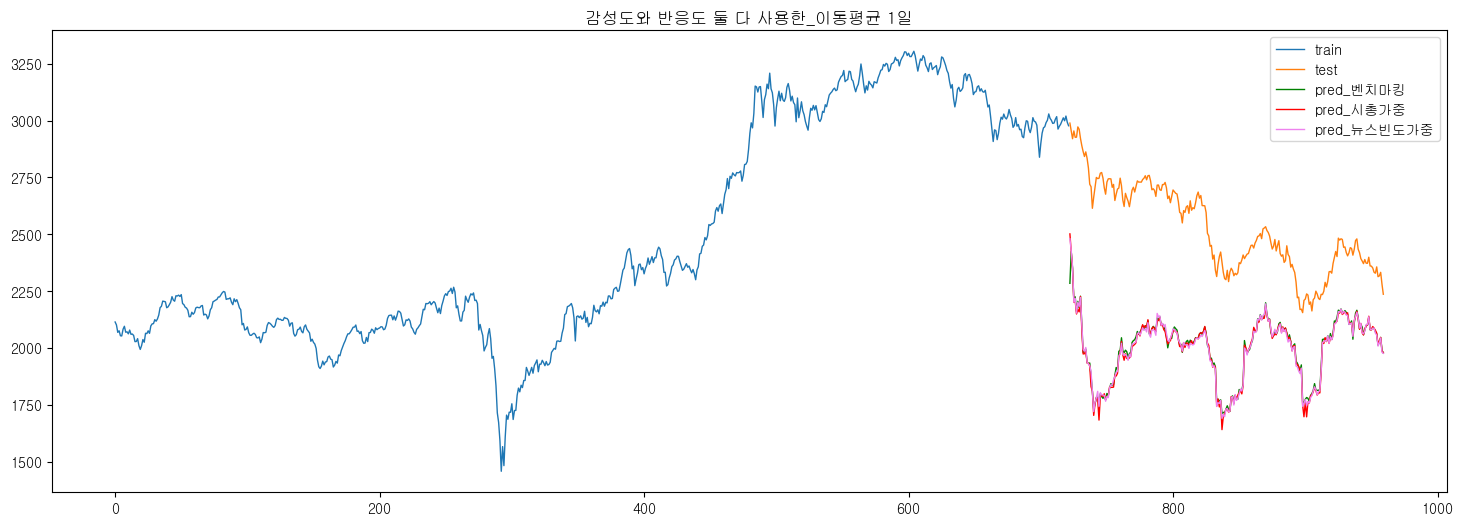

In [23]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성수치_벤치마킹', '반응도_벤치마킹','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_mc', '반응도_mc','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_ns', '반응도_ns','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred_벤치마킹', linewidth=1, color = 'green')
y_test_2['pred_시총가중'].plot(ax=ax, label='pred_시총가중', linewidth=1, color = 'red')
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred_뉴스빈도가중', linewidth=1, color = 'violet')
ax.set_title('감성도와 반응도 둘 다 사용한_이동평균 1일')
ax.legend();

RMSE: 545.846502
RMSE: 548.149596
RMSE: 557.701074


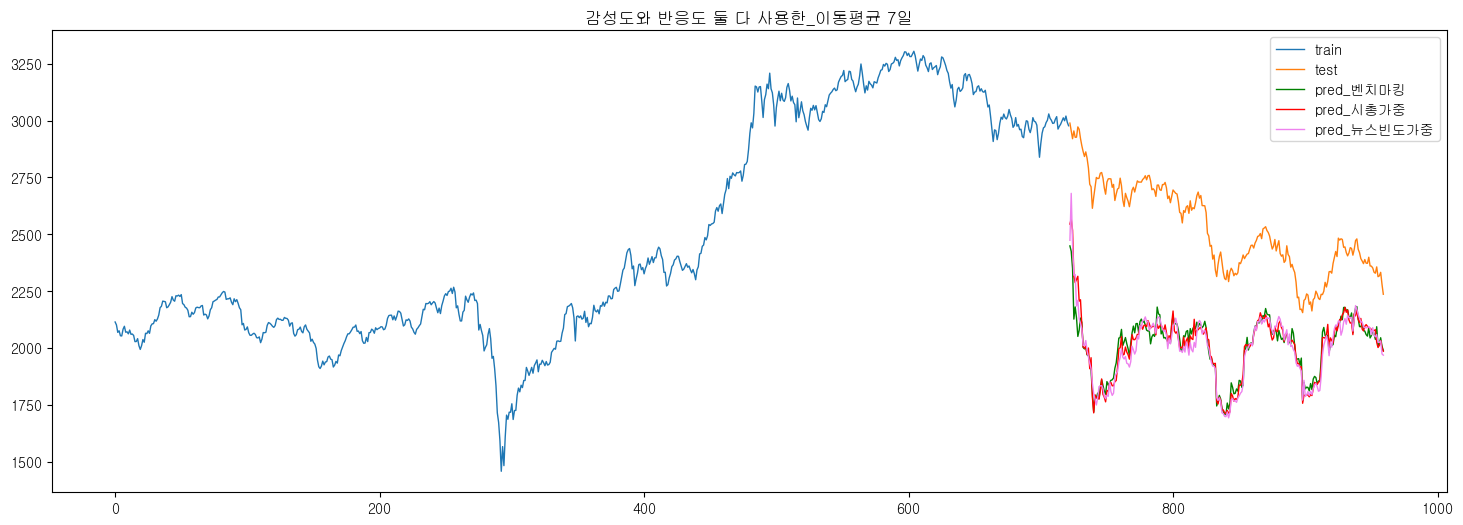

In [25]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성수치_벤치마킹_ma7', '반응도_벤치마킹_ma7','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_mc_ma7', '반응도_mc_ma7','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_ns_ma7', '반응도_ns_ma7','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred_벤치마킹', linewidth=1, color = 'green')
y_test_2['pred_시총가중'].plot(ax=ax, label='pred_시총가중', linewidth=1, color = 'red')
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred_뉴스빈도가중', linewidth=1, color = 'violet')
ax.set_title('감성도와 반응도 둘 다 사용한_이동평균 7일')
ax.legend();

RMSE: 544.053246
RMSE: 567.856754
RMSE: 548.317086


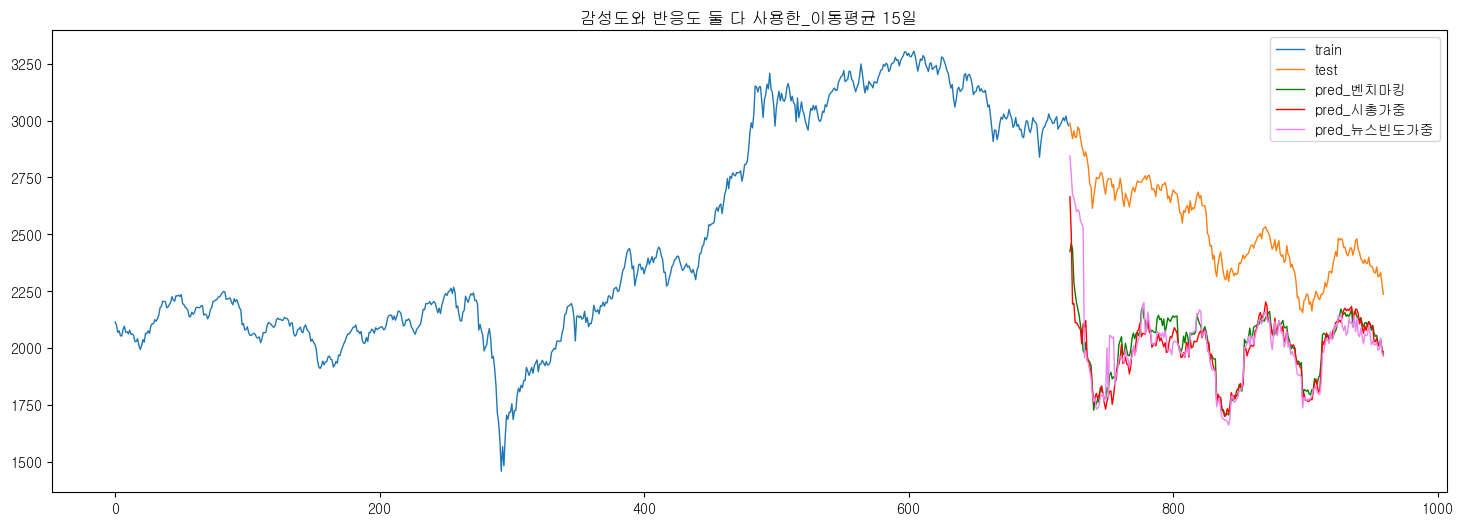

In [27]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성수치_벤치마킹_ma15', '반응도_벤치마킹_ma15','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_mc_ma15', '반응도_mc_ma15','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_ns_ma15', '반응도_ns_ma15','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred_벤치마킹', linewidth=1, color = 'green')
y_test_2['pred_시총가중'].plot(ax=ax, label='pred_시총가중', linewidth=1, color = 'red')
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred_뉴스빈도가중', linewidth=1, color = 'violet')
ax.set_title('감성도와 반응도 둘 다 사용한_이동평균 15일')
ax.legend();

RMSE: 520.115968
RMSE: 524.008558
RMSE: 469.236908


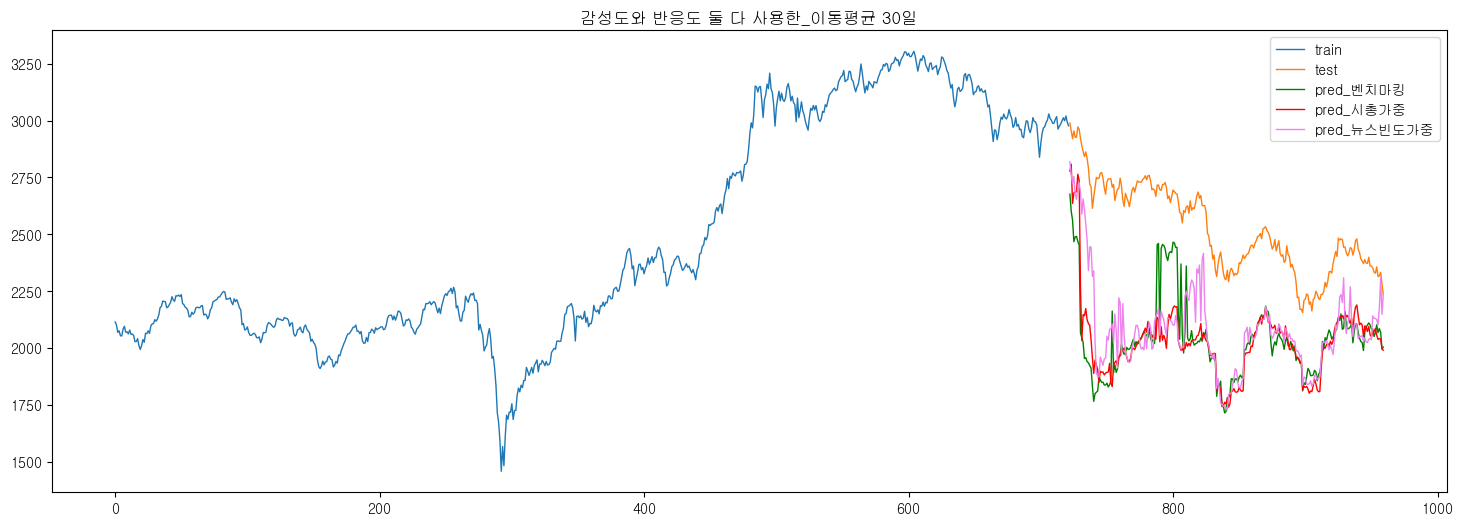

In [28]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성수치_벤치마킹_ma30', '반응도_벤치마킹_ma30','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_mc_ma30', '반응도_mc_ma30','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_ns_ma30', '반응도_ns_ma30','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred_벤치마킹', linewidth=1, color = 'green')
y_test_2['pred_시총가중'].plot(ax=ax, label='pred_시총가중', linewidth=1, color = 'red')
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred_뉴스빈도가중', linewidth=1, color = 'violet')
ax.set_title('감성도와 반응도 둘 다 사용한_이동평균 30일')
ax.legend();

RMSE: 561.829915
RMSE: 309.062936
RMSE: 426.994492


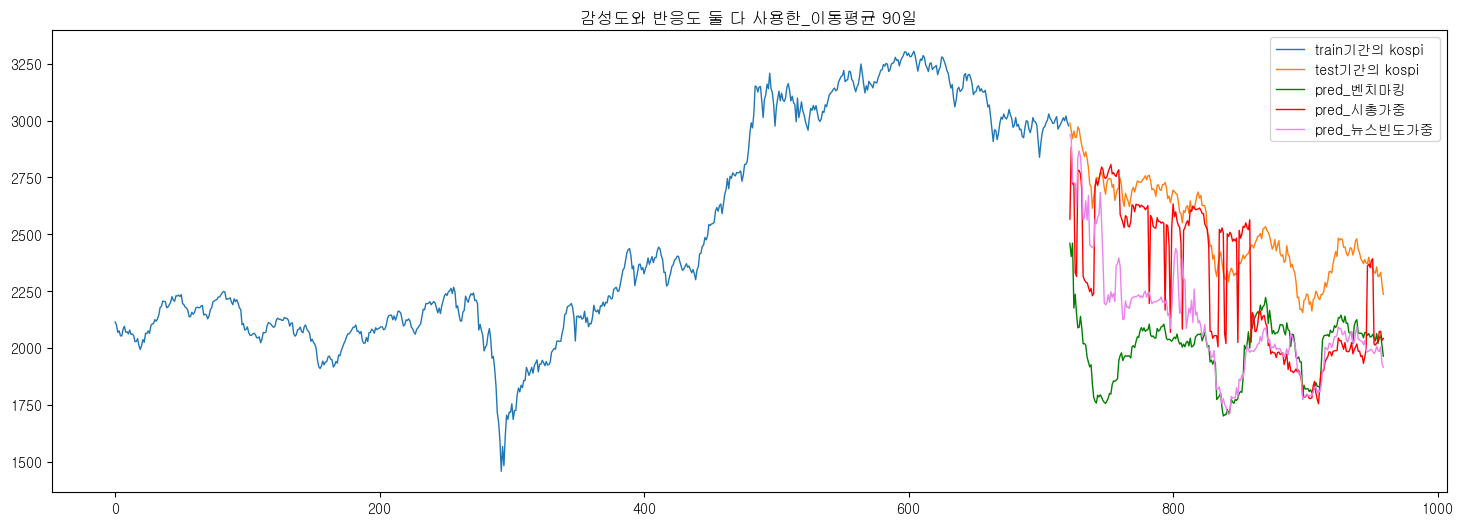

In [31]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성수치_벤치마킹_ma90', '반응도_벤치마킹_ma90','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_mc_ma90', '반응도_mc_ma90','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성수치_ns_ma90', '반응도_ns_ma90','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train기간의 kospi', linewidth=1)
y_test_1.close.plot(ax=ax, label='test기간의 kospi', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred_벤치마킹', linewidth=1, color = 'green')
y_test_2['pred_시총가중'].plot(ax=ax, label='pred_시총가중', linewidth=1, color = 'red')
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred_뉴스빈도가중', linewidth=1, color = 'violet')
ax.set_title('감성도와 반응도 둘 다 사용한_이동평균 90일')
ax.legend();

# 감성 * 반응 벤치마킹

RMSE: 562.242000
RMSE: 564.142479
RMSE: 561.376150


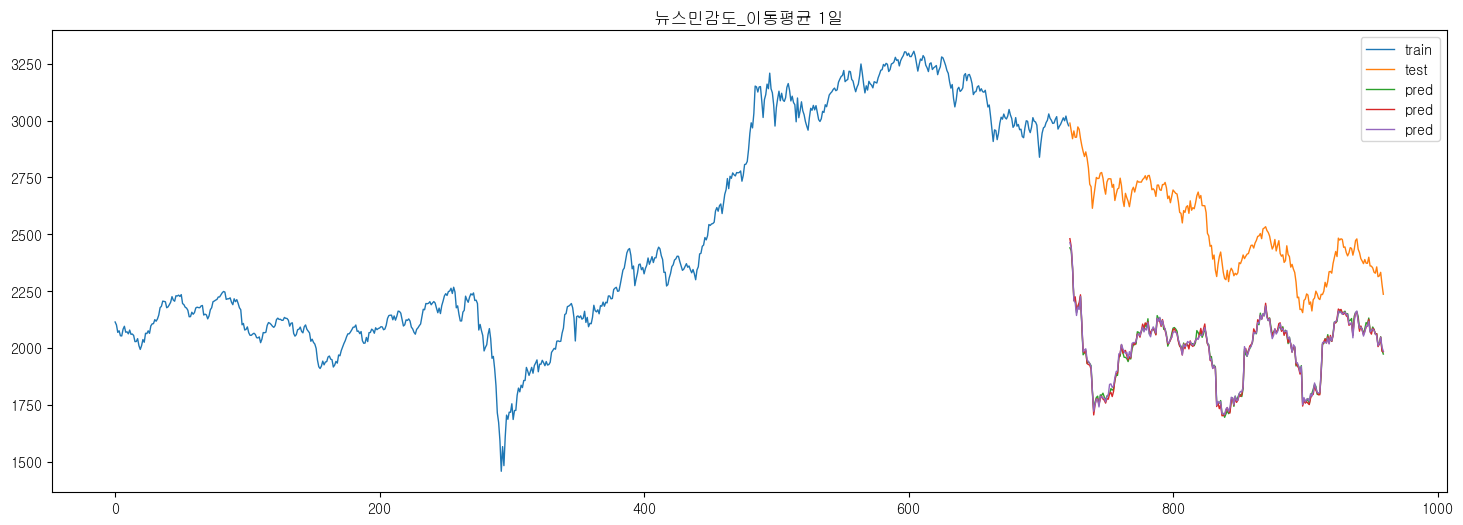

In [115]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성+반응','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성+반응_mc','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성+반응_ns','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('뉴스민감도_이동평균 1일')
ax.legend();

RMSE: 555.596382
RMSE: 542.581810
RMSE: 552.754457


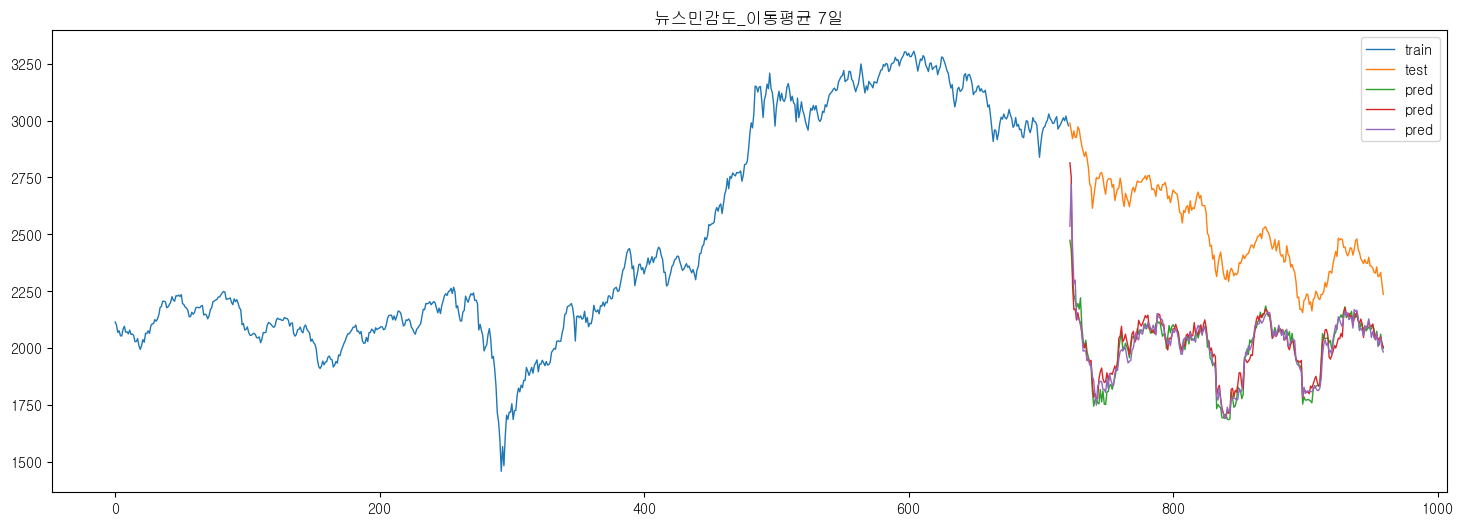

In [117]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성+반응_벤치마킹_ma7','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성+반응_mc_ma7','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성+반응_ns_ma7','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('뉴스민감도_이동평균 7일')
ax.legend();

RMSE: 544.951283
RMSE: 560.551240
RMSE: 531.695700


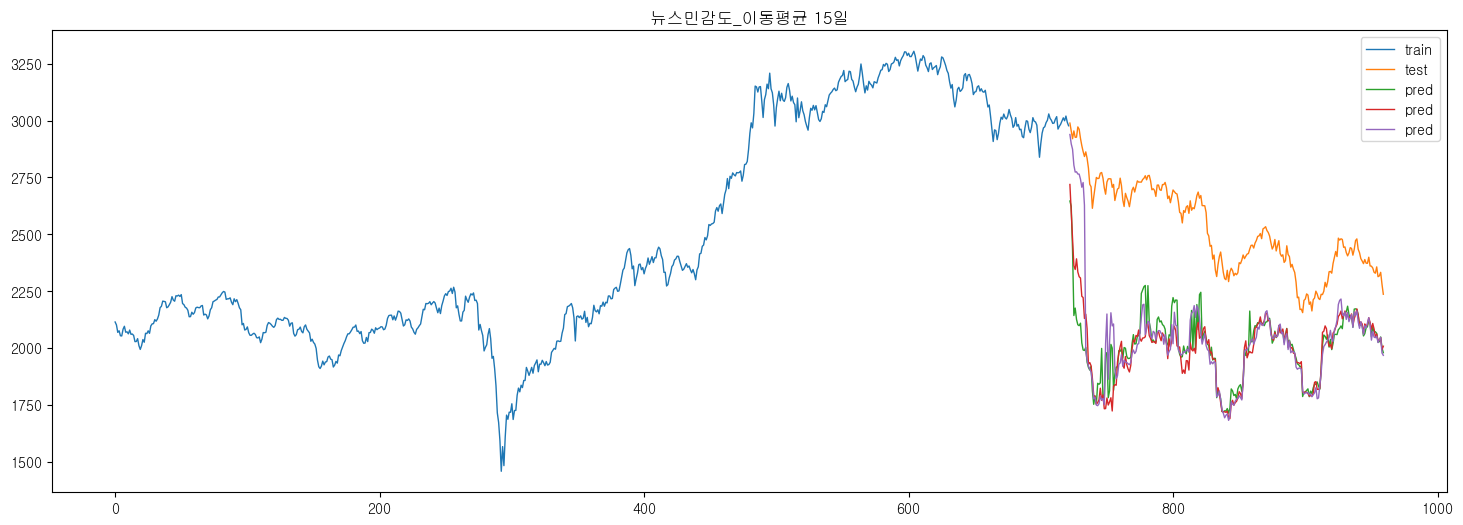

In [118]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성+반응_벤치마킹_ma15','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성+반응_mc_ma15','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성+반응_ns_ma15','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('뉴스민감도_이동평균 15일')
ax.legend();

RMSE: 465.605076
RMSE: 527.445389
RMSE: 469.913181


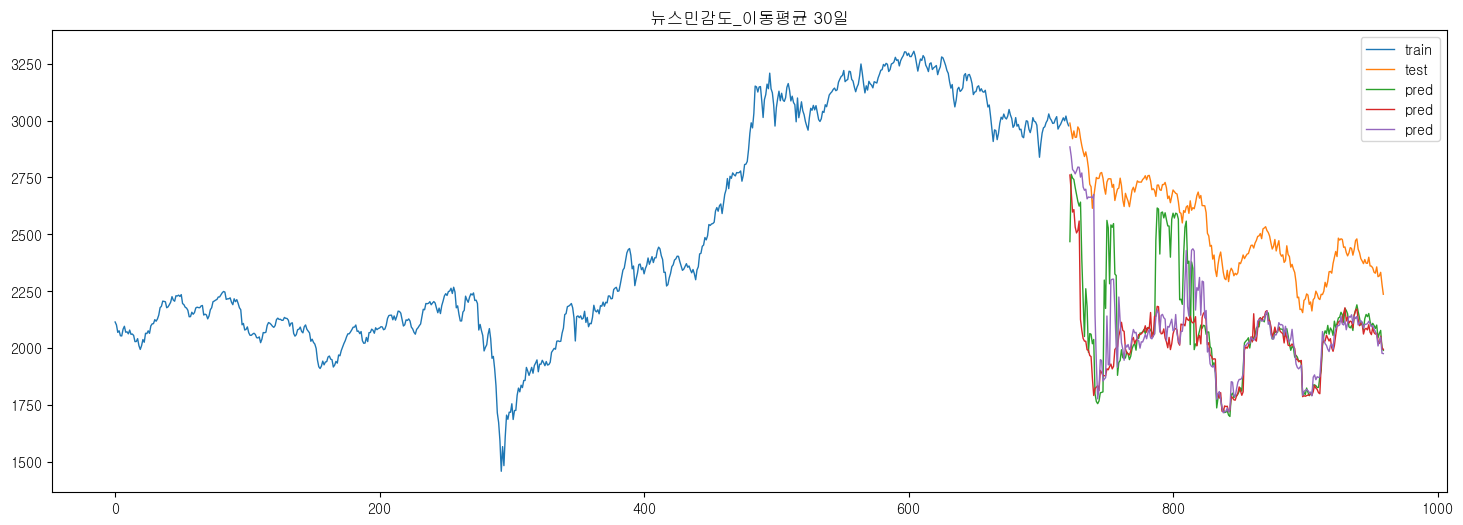

In [120]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성+반응_벤치마킹_ma30','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성+반응_mc_ma30','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성+반응_ns_ma30','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('뉴스민감도_이동평균 30일')
ax.legend();

RMSE: 549.471719
RMSE: 557.247091
RMSE: 540.274964


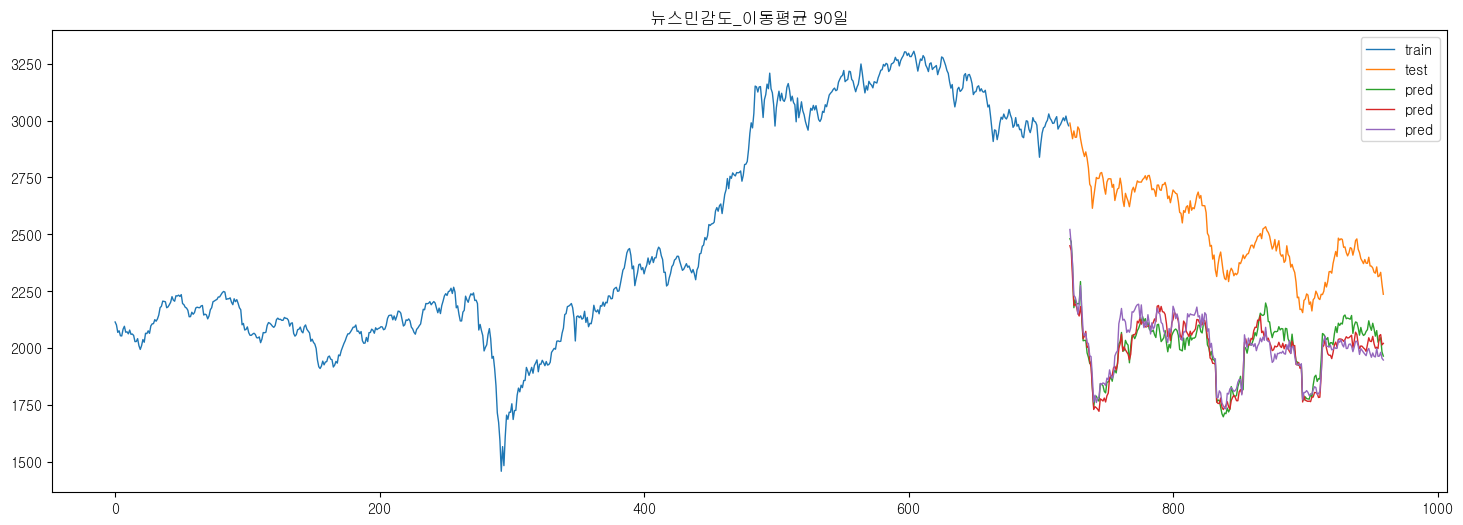

In [121]:
# 벤치마킹 =========================================================================
import xgboost as xgb
from sklearn.model_selection import train_test_split

y = d_set.iloc[:,:1]
x = d_set[['감성+반응_벤치마킹_ma90','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_1 = x.iloc[:722,:]
y_train_1 = y.iloc[:722,:]

X_test_1 = x.iloc[722:,:]
y_test_1 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_1,y_train_1)

preds = xg_reg.predict(X_test_1)

rmse = np.sqrt(mean_squared_error(y_test_1, preds))
print("RMSE: %f" % (rmse))
y_test_1['pred_벤치마킹'] = preds

# 시총가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성+반응_mc_ma90','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_2 = x.iloc[:722,:]
y_train_2 = y.iloc[:722,:]

X_test_2 = x.iloc[722:,:]
y_test_2 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_2,y_train_2)

preds = xg_reg.predict(X_test_2)

rmse = np.sqrt(mean_squared_error(y_test_2, preds))
print("RMSE: %f" % (rmse))
y_test_2['pred_시총가중'] = preds

# 뉴스빈도가중 =========================================================================
y = d_set.iloc[:,:1]
x = d_set[['감성+반응_ns_ma90','ADX', 'ADXR', 'APO', 'aroondown', 'aroonup',
       'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'macdsignal', 'macdhist',
       'ma_macd', 'ma_macdsignal', 'ma_macdhist', 'fix_macd', 'fix_macdsignal',
       'fix_macdhist', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DM', 'PPO',
       'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk',
       'fastd', 'TRIX', 'ULTOSC', 'WILLR']]

X_train_3 = x.iloc[:722,:]
y_train_3 = y.iloc[:722,:]

X_test_3 = x.iloc[722:,:]
y_test_3 = y.iloc[722:,:]

xg_reg = xgb.XGBRegressor(n_estimators = 200, learning_rate = 0.1, random_state = 123)
xg_reg.fit(X_train_3,y_train_3)

preds = xg_reg.predict(X_test_3)

rmse = np.sqrt(mean_squared_error(y_test_3, preds))
print("RMSE: %f" % (rmse))
y_test_3['pred_뉴스빈도가중'] = preds

# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(18, 6))
y_train_1.close.plot(ax=ax, label='train', linewidth=1)
y_test_1.close.plot(ax=ax, label='test', linewidth=1)

y_test_1['pred_벤치마킹'].plot(ax=ax, label='pred', linewidth=1)
y_test_2['pred_시총가중'].plot(ax=ax, label='pred', linewidth=1)
y_test_3['pred_뉴스빈도가중'].plot(ax=ax, label='pred', linewidth=1)
ax.set_title('뉴스민감도_이동평균 90일')
ax.legend();